# GIF generation using the TiTiler /cog/crop endpoint 


* Author: Leo Thomas
* Last updated: August 30th 2022

This notebook demonstrates how to use the `/cog/crop` endpoint to generate GIFs from data in the VEDA API. 

The overall process will be: 
1. Use the STAC API to gather a list of STAC items which will each become on frame in our gif
2. Query the `/cog/crop` endpoint with the asset URL and a geojson geometry
3. Stack all of the generated images into a animated GIF


## Import relevant libraries

In [1]:
# Standard lib imports
from concurrent.futures import ThreadPoolExecutor
import datetime
import glob
import json
import os
import requests as re
import tempfile
import time
import io
from IPython import display
import warnings
warnings.filterwarnings("ignore")

# 3rd party imports
import folium
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import rasterio
import rasterio.features
import rasterio.plot
from scipy.ndimage import binary_dilation
import selenium.webdriver

/Users/aimeebarciauskas/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Define global variables

In [2]:
STAC_API_URL = "https://staging-stac.delta-backend.com"
RASTER_API_URL = "https://staging-raster.delta-backend.com"

# Collection we'll be using to generate the GIF
collection = 'no2-monthly'

## Define an AOI to crop the COG data

In [4]:
# GeoJSON for metropolitan France and Corsica (excluding overseas territories)
france_aoi = { 
    "type": "Feature", 
    "properties": { 
        "ADMIN": "France", 
        "ISO_A3": "FRA" 
    }, 
    "geometry": { 
        "type": "MultiPolygon", 
        "coordinates": [[[[9.476898634000122,42.62010325700014],[9.476817254000139,42.619086005000085],[9.45655358200014,42.64740631700012],[9.48210696700005,42.62010325700014],[9.476898634000122,42.62010325700014]]],[[[9.44939212300011,42.68260325700008],[9.450368686000076,42.653631903000175],[9.449066602000073,42.651068427000084],[9.446055535000085,42.64858633000013],[9.443369988000086,42.645249742000104],[9.442881707000112,42.64057038],[9.445323113000143,42.637884833000115],[9.449961785000085,42.63572825700011],[9.454600457000083,42.63458893400018],[9.45655358200014,42.63442617400004],[9.45923912900011,42.625433661],[9.461680535000141,42.619818427],[9.461436394000117,42.61456940300012],[9.45655358200014,42.606431382],[9.46461022200009,42.60162995000012],[9.468028191000087,42.59495677300005],[9.470713738000057,42.58722565300006],[9.476898634000122,42.579169012000094],[9.484873894000089,42.57444896],[9.511892123000052,42.56549713700015],[9.50912519600007,42.57998281500012],[9.504730665000096,42.586615302],[9.489593946000099,42.61261627800015],[9.518565300000091,42.5809593770001],[9.528086785000085,42.56354401200004],[9.53223717500012,42.544378973000065],[9.530039910000141,42.48631419500002],[9.53337649800008,42.45624420800006],[9.545909050000148,42.43512604400014],[9.539886915000068,42.42206452000006],[9.535411004000082,42.40818919499999],[9.532725457000112,42.392523505],[9.53223717500012,42.373724677000055],[9.53695722700013,42.35317617400001],[9.555430535000141,42.31427643400012],[9.559580925000091,42.29458242400007],[9.552256707000083,42.170152085000055],[9.559580925000091,42.14655182500003],[9.55689537900011,42.13825104400014],[9.554942254000082,42.120835679],[9.552744988000086,42.113023179],[9.545583530000044,42.10398997599999],[9.518565300000091,42.08510976800015],[9.507823113000086,42.07221100500011],[9.492442254000139,42.0477562520001],[9.423838738000114,41.97353750200007],[9.408702019000117,41.96222565300009],[9.403168165000096,41.952948309000035],[9.402842644000089,41.91742584800015],[9.394297722000147,41.84796784100003],[9.403005405000044,41.779730536000116],[9.401621941000144,41.70644765800007],[9.398610873000052,41.70148346600003],[9.391123894000089,41.69904205900009],[9.381195509000094,41.69269440300015],[9.372243686000047,41.683905341000084],[9.367035352000073,41.674221096000124],[9.380707227000102,41.674221096000124],[9.37794030000012,41.65643952000015],[9.373057488000057,41.64516836100016],[9.363617384000065,41.64004140800013],[9.353200717000078,41.64081452000006],[9.345225457000112,41.64032623900009],[9.342133009000122,41.63467031500009],[9.346690300000148,41.61957428600009],[9.333262566000087,41.62445709800015],[9.318207227000073,41.62714264500012],[9.30372155000012,41.62783437700007],[9.292165561000076,41.626410223],[9.293955925000063,41.617621161000116],[9.284434441000087,41.60765208500014],[9.278575066000116,41.59837474199999],[9.292165561000076,41.59162018400015],[9.325043165000068,41.60195547100015],[9.345062696000127,41.60447825700008],[9.354177280000044,41.59540436400009],[9.350596550000148,41.581203518000066],[9.341075066000059,41.56928131700012],[9.326670769000089,41.56110260600012],[9.30909264400006,41.558172919000086],[9.299652540000068,41.55329010600012],[9.292165561000076,41.54291413000011],[9.281993035000141,41.533270575000145],[9.264659050000148,41.53082916900003],[9.268728061000104,41.52374909100014],[9.269867384000065,41.51679108300006],[9.268728061000104,41.50995514500015],[9.264659050000148,41.50287506700009],[9.276215040000068,41.4994164080001],[9.279144727000102,41.49164459800009],[9.274750196000127,41.482855536000116],[9.264659050000148,41.47614166900017],[9.270843946000127,41.46873607],[9.255218946000127,41.46360911699999],[9.228037957000112,41.45001862200003],[9.210703972000147,41.44822825700014],[9.210703972000147,41.44086334800012],[9.22006269600007,41.43504466400019],[9.223317905000016,41.42731354400017],[9.219981316000087,41.41962311400006],[9.210703972000147,41.413519598000065],[9.210703972000147,41.407294012000094],[9.222015821000127,41.410956122000144],[9.23796634200005,41.422267971000124],[9.250336134000065,41.427801825000145],[9.246592644000117,41.412909247000115],[9.238780144000145,41.39590078300013],[9.23015384200005,41.38092682500012],[9.223155144000145,41.372503973000065],[9.206716342000078,41.365912177],[9.193858269000145,41.36912669500005],[9.169118686000076,41.386175848],[9.15333092500012,41.391343492000104],[9.122243686000104,41.39496491100006],[9.096446160000085,41.403509833000086],[9.107269727000073,41.42926666900003],[9.11215254000004,41.43256256700006],[9.12134850400011,41.43463776200018],[9.105153842000078,41.44550202000006],[9.080902540000068,41.45319245000009],[9.06657962300008,41.46190013200008],[9.079844597000118,41.47614166900017],[9.079844597000118,41.48236725500014],[9.068207227000102,41.479478257000025],[9.03874759200005,41.46190013200008],[9.031993035000085,41.46873607],[9.034190300000091,41.47089264500009],[9.03541100400011,41.47162506700012],[9.036631707000112,41.47284577000012],[9.03874759200005,41.47614166900017],[9.028086785000113,41.473822333000115],[9.024099155000044,41.472113348],[9.018321160000141,41.46873607],[9.011485222000147,41.47614166900017],[9.000987175000063,41.483058986000074],[8.975596550000148,41.48908112200017],[8.95101972700013,41.49188873900012],[8.93572024800008,41.48920319200015],[8.924815300000091,41.49494049700003],[8.916758660000056,41.50165436400006],[8.906911655000044,41.50731028900016],[8.883636915000125,41.511175848000065],[8.88111412900011,41.514837958000115],[8.879161004000082,41.51935455900018],[8.873708530000044,41.52338288000014],[8.86426842500012,41.525336005],[8.856293165000068,41.525336005],[8.848399285000085,41.526109117000104],[8.839610222000118,41.53082916900003],[8.853282097000147,41.537665106000034],[8.853282097000147,41.54385000200001],[8.840586785000085,41.54726797100001],[8.83334394600007,41.55072663000011],[8.82390384200005,41.549953518000095],[8.809906446000099,41.55267975500006],[8.797211134000122,41.557074286000145],[8.791758660000085,41.561224677],[8.796397332000112,41.58055247600011],[8.793223504000139,41.58730703300013],[8.778086785000141,41.59162018400015],[8.785411004000053,41.604681708000115],[8.79200280000012,41.6251488300001],[8.801768425000091,41.63906484600007],[8.819021030000073,41.63263580900015],[8.872569207000083,41.651068427],[8.88111412900011,41.6571312520001],[8.885752800000148,41.67088450700011],[8.896983269000145,41.67792389500009],[8.910655144000089,41.68382396000011],[8.922699415000096,41.69464752800012],[8.899180535000141,41.695461330000015],[8.836436394000145,41.708929755],[8.81234785200013,41.70929596600003],[8.788828972000061,41.71255117400007],[8.776133660000113,41.722398179],[8.78492272200009,41.74249909100003],[8.760101759000122,41.74266185099999],[8.719086134000122,41.730698960000055],[8.695567254000139,41.72943756700006],[8.698090040000068,41.73305898600002],[8.70297285200013,41.74249909100003],[8.688731316000144,41.741766669000114],[8.67798912900011,41.74408600500006],[8.667979363000143,41.747503973000065],[8.655121290000125,41.74990469000012],[8.668223504000082,41.75486888200008],[8.696299675000091,41.75820547100001],[8.70915774800011,41.763576565000065],[8.717539910000085,41.77204010600009],[8.722015821000127,41.782416083],[8.72022545700014,41.791693427000055],[8.70915774800011,41.79706452],[8.70915774800011,41.80451080900018],[8.73194420700014,41.804592190000065],[8.752289259000122,41.80980052300005],[8.78492272200009,41.82440827000009],[8.780039910000113,41.833929755000085],[8.772308790000096,41.840399481000176],[8.762380405000101,41.84414297100001],[8.750824415000068,41.84552643400009],[8.783702019000145,41.85358307500003],[8.791758660000085,41.85911692900005],[8.789317254000139,41.86131419500005],[8.785817905000073,41.86798737200009],[8.781748894000117,41.873683986000074],[8.778086785000141,41.872788804],[8.790049675000091,41.886948960000026],[8.791758660000085,41.88711172100007],[8.79460696700005,41.892157294000086],[8.803396030000101,41.90053945500016],[8.805430535000113,41.906927802],[8.803070509000065,41.90745677300005],[8.791758660000085,41.913763739],[8.785980665000125,41.922837632],[8.78142337300008,41.92877838700004],[8.77507571700005,41.93231842700003],[8.764414910000113,41.934271552000055],[8.744395379000139,41.932806708],[8.710297071000127,41.91876862200006],[8.688731316000144,41.913763739],[8.647634311000047,41.91181061400006],[8.629893425000148,41.908636786],[8.614268425000148,41.90078359600001],[8.607269727000102,41.913763739],[8.61866295700014,41.93048737200003],[8.614431186000047,41.94407786699999],[8.586273634000065,41.96898021000011],[8.635508660000141,41.97264232],[8.655039910000141,41.97870514500006],[8.668793165000068,41.99632396],[8.656097852000102,42.00287506700009],[8.664561394000117,42.01447174700009],[8.684336785000141,42.02558014500012],[8.70606530000012,42.030462958],[8.711273634000122,42.03327057500006],[8.738047722000118,42.04393138200008],[8.743418816000087,42.044134833000115],[8.744965040000125,42.05658600500006],[8.739105665000068,42.06342194200006],[8.723480665000096,42.07208893400015],[8.706228061000076,42.1004906270001],[8.699229363000114,42.10932038000014],[8.688812696000127,42.11115143400012],[8.660899285000085,42.10545482000005],[8.655121290000125,42.10932038000014],[8.647715691000116,42.122015692],[8.629567905000044,42.13007233300014],[8.606700066000116,42.133734442],[8.586273634000065,42.133490302000055],[8.591075066000144,42.14288971600017],[8.593760613000114,42.14655182500003],[8.586273634000065,42.151434637000094],[8.578135613000114,42.154201565000065],[8.569102410000113,42.154974677000084],[8.55958092500012,42.153998114],[8.569672071000099,42.15558502800003],[8.57789147200009,42.15875885600009],[8.593760613000114,42.16705963700018],[8.593760613000114,42.174505927000055],[8.565765821000099,42.174505927000055],[8.565765821000099,42.1813011740001],[8.57764733200014,42.18488190300015],[8.58179772200009,42.194525458000115],[8.577810092000107,42.20441315300003],[8.565765821000099,42.20856354400017],[8.574066602000073,42.21991608300006],[8.565765821000099,42.225734768],[8.552419467000078,42.22898997600005],[8.545258009000122,42.23285553600006],[8.549489780000073,42.242254950000174],[8.559906446000042,42.244330145],[8.586273634000065,42.243353583000115],[8.593760613000114,42.24628327000015],[8.601328972000147,42.25067780200011],[8.61085045700014,42.254624742000104],[8.651133660000141,42.260402736000074],[8.664724155000101,42.26487864800005],[8.675059441000087,42.270656643],[8.680837436000076,42.27277252800012],[8.68523196700005,42.271918036000116],[8.687754754000053,42.27293528900016],[8.688731316000144,42.28095123900012],[8.674001498000052,42.289496161000145],[8.67204837300011,42.29116445500016],[8.634776238000114,42.3048363300001],[8.632334832000083,42.30866120000012],[8.629649285000113,42.31525299700009],[8.625173373000052,42.31915924700009],[8.61109459700009,42.31004466400019],[8.60531660200013,42.310451565],[8.60141035200013,42.314764716000084],[8.59986412900011,42.321926174000126],[8.604746941000087,42.3255882830001],[8.634776238000114,42.338934637000094],[8.612803582000112,42.35244375200007],[8.591563347000118,42.351141669000086],[8.55209394600007,42.338934637000094],[8.55958092500012,42.346380927],[8.553477410000141,42.354885158000016],[8.549652540000125,42.36579010600009],[8.549082879000139,42.37710195500007],[8.55209394600007,42.38670482000005],[8.560801629000139,42.38165924700003],[8.57048587300011,42.381781317],[8.579600457000083,42.385931708000115],[8.586273634000065,42.39297109600001],[8.598643425000091,42.38760000200013],[8.602386915000125,42.39191315300006],[8.603526238000143,42.400336005],[8.607269727000102,42.407212632000025],[8.612071160000085,42.411810614000146],[8.614024285000113,42.41624583500011],[8.61866295700014,42.419582424000126],[8.650889519000089,42.42328522300009],[8.659515821000099,42.42987702000006],[8.661631707000112,42.43976471600017],[8.661387566000144,42.451890367000075],[8.672373894000117,42.46442291900014],[8.676768425000091,42.47247955900009],[8.67204837300011,42.47614166900014],[8.65967858200014,42.477118231000034],[8.657074415000068,42.48004791900014],[8.659353061000047,42.48436107000005],[8.66749108200014,42.509711005],[8.680430535000141,42.52106354400014],[8.697601759000094,42.52700429900007],[8.71656334700009,42.53070709800012],[8.71078535200013,42.540106512000065],[8.71631920700014,42.56199778900016],[8.70915774800011,42.57172272300012],[8.70915774800011,42.579169012000094],[8.71697024800011,42.57611725500011],[8.719737175000148,42.575995184000035],[8.72087649800011,42.574123440000065],[8.723480665000096,42.56549713700015],[8.740000847000061,42.57233307500009],[8.750661655000101,42.56879303600003],[8.75961347700013,42.56175364800005],[8.771250847000147,42.558050848],[8.786957227000102,42.56199778900016],[8.798838738000143,42.57176341400013],[8.807465040000068,42.58510976800012],[8.812836134000122,42.59959544499999],[8.805430535000113,42.606431382],[8.843028191000116,42.60805898600002],[8.906504754000139,42.63247304900007],[9.018321160000141,42.650132554],[9.049978061000047,42.66217682500009],[9.052989129000139,42.68158600500003],[9.107106967000107,42.72589752800015],[9.117849155000044,42.73200104400006],[9.141449415000068,42.73501211100013],[9.165212436000076,42.735174872000115],[9.176036004000053,42.73281484600015],[9.185069207000083,42.73338450700011],[9.236827019000089,42.72256094000012],[9.257823113000143,42.71393463700012],[9.264659050000148,42.70888906500009],[9.270843946000127,42.70221588700004],[9.276133660000085,42.69415924700009],[9.28532962300008,42.674750067],[9.292165561000076,42.674750067],[9.327891472000118,42.72003815300012],[9.342539910000113,42.74909088700018],[9.33301842500012,42.77094147300012],[9.340993686000076,42.790106512000094],[9.335459832000083,42.80760325700005],[9.32178795700014,42.82391998900006],[9.305674675000148,42.839260158000016],[9.33301842500012,42.86713288000006],[9.332855665000068,42.875799872000144],[9.32634524800008,42.88532135600015],[9.326182488000114,42.89378489800002],[9.33025149800008,42.90355052300005],[9.33692467500012,42.910386460000055],[9.360199415000125,42.92861562700013],[9.356781446000127,42.93353913],[9.355723504000082,42.93650950700011],[9.356944207000083,42.94065989800005],[9.360199415000125,42.94912344],[9.349945509000122,42.95722077000012],[9.343435092000107,42.973089911000145],[9.341807488000086,42.99066803600009],[9.346690300000148,43.00372955900015],[9.36304772200009,43.011542059000064],[9.404307488000143,43.01166413000011],[9.422373894000145,43.01740143400009],[9.435557488000114,43.00372955900015],[9.444509311000047,42.997992255],[9.464040561000104,42.99005768400012],[9.464040561000104,42.98261139500015],[9.45557701900006,42.97455475500003],[9.453868035000056,42.963812567],[9.458750847000118,42.95233795800006],[9.470062696000127,42.94228750200007],[9.465505405000073,42.92352936400012],[9.484385613000114,42.83242422100001],[9.482758009000094,42.80231354400017],[9.450368686000076,42.70888906500009],[9.451426629000139,42.696722723],[9.44939212300011,42.68260325700008]]],[[[6.251004127000073,43.017296825000145],[6.2522088260001,43.00263219800003],[6.23023522200009,42.99534739799999],[6.216481967000078,42.99038320500013],[6.202484571000099,42.98712799700009],[6.190114780000073,42.990179755],[6.166188998000109,42.99966054900001],[6.164724155000044,43.00507233300014],[6.175140821000127,43.00897858300014],[6.202972852000102,43.00800202000006],[6.211599155000101,43.01162344000012],[6.215017123000109,43.01471588700012],[6.21827233200014,43.015448309000035],[6.221039259000122,43.01496002800015],[6.233393453000105,43.01558154300015],[6.235036655000073,43.02240631700012],[6.241884786000128,43.02564971800008],[6.251004127000073,43.017296825000145]]],[[[-1.285145636999886,46.00165436400006],[-1.273833787999905,45.997626044000086],[-1.261219855999912,46.000677802],[-1.247629360999952,46.001776434000035],[-1.233631964999887,45.99168528900016],[-1.229562954999921,45.97923411700005],[-1.231190558999856,45.967922268000066],[-1.230458136999914,45.958197333000115],[-1.219390428999901,45.95075104400014],[-1.219390428999901,45.943915106000034],[-1.224354620999861,45.93504466400016],[-1.213937954999949,45.928045966000084],[-1.185170050999915,45.915961005],[-1.177723761999943,45.906927802],[-1.176096157999922,45.898749091000084],[-1.184193488999938,45.8563500020001],[-1.194569464999944,45.83006419499999],[-1.209217902999853,45.81415436400006],[-1.22687740799995,45.819769598000065],[-1.241200324999852,45.854559637000094],[-1.249419725999928,45.86774323100015],[-1.26036536399991,45.881822007],[-1.31899980399993,45.92812734600007],[-1.34015865799995,45.93866608300014],[-1.361724412999934,45.95673248900006],[-1.3783259759999,45.975978908000016],[-1.373890753999945,45.984930731000034],[-1.371652798999946,45.995306708000115],[-1.382923956999946,46.01850006700006],[-1.404937303999958,46.053168036000145],[-1.373890753999945,46.05023834800012],[-1.339914516999897,46.03782786699999],[-1.308705206999917,46.020249742000075],[-1.285145636999886,46.00165436400006]]],[[[-1.467884894999884,46.24990469],[-1.467437303999901,46.24396393400009],[-1.473866339999887,46.238104559000035],[-1.497710740999878,46.245184637000094],[-1.507964647999899,46.24555084800012],[-1.490549282999922,46.22443268400009],[-1.464182094999927,46.224920966000084],[-1.435454881999903,46.23383209800012],[-1.411122199999909,46.238104559000035],[-1.411122199999909,46.23126862200003],[-1.425363735999923,46.23126862200003],[-1.425363735999923,46.22382233300006],[-1.408762173999946,46.218247789000046],[-1.308094855999855,46.206935940000065],[-1.284738735999952,46.196437893000095],[-1.265736456999946,46.18097565300015],[-1.254139777999853,46.16242096600014],[-1.26341712099989,46.161851304],[-1.27086341099988,46.160223700000145],[-1.281402147999927,46.15619538],[-1.286284959999904,46.16010163],[-1.290679490999906,46.161322333000115],[-1.336089647999899,46.16722239800005],[-1.432850714999887,46.21084219000015],[-1.488921678999901,46.20335521],[-1.50426184799997,46.207668361000074],[-1.544829881999874,46.239894924000126],[-1.555816209999932,46.24555084800012],[-1.555816209999932,46.25177643400018],[-1.498117641999897,46.26190827000012],[-1.480091925999943,46.259222723000065],[-1.472727016999954,46.25527578300007],[-1.467884894999884,46.24990469]]],[[[-2.279693162999905,46.710272528000175],[-2.2689509759999,46.69741445500013],[-2.291371222999914,46.70359935100011],[-2.371408657999893,46.70429108300006],[-2.382923956999917,46.722642320000105],[-2.375152147999927,46.731634833000115],[-2.35680091099988,46.73379140800013],[-2.337228969999899,46.73159414300012],[-2.298207160999937,46.72016022300009],[-2.279693162999905,46.710272528000175]]],[[[-2.189808722999914,46.977240302],[-2.155751105999883,46.96491120000006],[-2.144846157999922,46.95746491100006],[-2.140044725999928,46.94342682500012],[-2.13768469999988,46.92316315300009],[-2.142567511999857,46.90985748900009],[-2.159087693999908,46.91648997600005],[-2.173695441999939,46.939154364],[-2.194813605999855,46.96185944200015],[-2.220204230999883,46.97386302300008],[-2.247303839999916,46.96430084800009],[-2.263172980999855,46.97980377800009],[-2.278675910999937,47.018133856000034],[-2.295643683999913,47.03318919500005],[-2.238596157999922,47.03534577000015],[-2.220448370999918,47.03318919500005],[-2.200021938999953,47.02435944200009],[-2.19741777299987,47.01300690300012],[-2.201324022999955,46.999741929],[-2.200103318999936,46.985419012000094],[-2.189808722999914,46.977240302]]],[[[-3.114654100999871,47.331488348],[-3.102691209999932,47.32733795800006],[-3.072743292999888,47.32831452000015],[-3.062814907999893,47.32062409100003],[-3.06700598899991,47.30194733300014],[-3.093617316999939,47.296616929],[-3.171701626999891,47.30158112200003],[-3.223459438999896,47.31216054900007],[-3.240956183999856,47.32062409100003],[-3.237619594999927,47.33637116100009],[-3.245350714999944,47.35285065300015],[-3.256174282999922,47.36880117400007],[-3.26207434799997,47.383246161000116],[-3.253651495999918,47.38886139500012],[-3.249623175999943,47.395209052000055],[-3.242990688999896,47.39533112200003],[-3.234120245999918,47.38955312700007],[-3.221506313999953,47.38751862200006],[-3.176503058999884,47.37148672100015],[-3.151600714999916,47.35814036700005],[-3.148793097999885,47.35537344000009],[-3.114654100999871,47.331488348]]],[[[-5.04625403599988,48.47382233300014],[-5.042958136999914,48.47199127800015],[-5.036610480999883,48.47260163000011],[-5.036610480999883,48.46515534100014],[-5.087961391999897,48.447211005],[-5.105539516999926,48.44464752800009],[-5.105539516999926,48.45148346600003],[-5.10216223899991,48.45184967700011],[-5.095122850999871,48.451117255],[-5.091867641999897,48.45148346600003],[-5.097767706999946,48.461330471000124],[-5.107411261999914,48.46336497600008],[-5.132801886999943,48.45831940300003],[-5.132801886999943,48.46515534100014],[-5.091786261999914,48.48078034100003],[-5.068999803999901,48.485052802000055],[-5.05028235599994,48.478827216000084],[-5.048166469999927,48.47650788000011],[-5.04625403599988,48.47382233300014]]],[[[2.537033325000095,51.064610291000136],[2.547058553000113,51.020478618000155],[2.556980428000117,51.00117747000003],[2.592740519000131,50.9761144000001],[2.608450154000082,50.961128235000146],[2.611654093000055,50.94123280900014],[2.605762980000066,50.93523834300011],[2.582715291000113,50.92066558900014],[2.576927531000138,50.91151886000016],[2.596667928000102,50.867645569000146],[2.595531046000076,50.86113433900006],[2.587779582000081,50.850023906000146],[2.586746053000098,50.845424704000024],[2.589949992000072,50.84201405900008],[2.602042277000066,50.838086649],[2.606589803000077,50.83483103400012],[2.615168091000015,50.82217030900007],[2.620439087000136,50.81648590200014],[2.627777140000148,50.81441884400009],[2.642453247000049,50.812455139000136],[2.650618123000044,50.81224843400018],[2.669221639000114,50.81390207900013],[2.678730102000088,50.81323028600015],[2.691855916000066,50.808837789000066],[2.696920207000119,50.803050028000186],[2.700020792000089,50.79628041600013],[2.706635376000065,50.78878733400002],[2.743842407000074,50.76620473200008],[2.74952681500011,50.759590149000175],[2.762962687000083,50.739384665],[2.768233683000119,50.733235169000025],[2.786733846000033,50.723364970000134],[2.86672588400009,50.70009100300008],[2.87127648900011,50.69876698900005],[2.886882772000149,50.69664825500017],[2.900111938000038,50.70310780900003],[2.930187622000119,50.73623240200014],[2.948377726000047,50.74868642200012],[2.971425415000113,50.75783315000011],[3.023816593000049,50.76826211600003],[3.103303671000049,50.784084778000036],[3.129245239000085,50.77907216500007],[3.146195109000104,50.76889190700011],[3.162810519000061,50.749939075000114],[3.162822752000096,50.74992512100003],[3.176684204000082,50.73411366800015],[3.188983195000049,50.715096742000085],[3.1969413650001,50.70920562800008],[3.210997355000103,50.707965394000055],[3.224433227000077,50.705174866],[3.232391398000118,50.69592478500009],[3.243760213000115,50.67210195000011],[3.229807576000042,50.65541046200018],[3.237869100000097,50.62647166],[3.264327433000091,50.57019602500013],[3.265877726000042,50.538311666000155],[3.27104537000011,50.52694285100007],[3.286755005000089,50.51407542000008],[3.299880819000066,50.50746083600008],[3.343599080000047,50.49293975900004],[3.361065714000091,50.489787497000165],[3.385353637000094,50.49164784800017],[3.429175252000078,50.50182810500014],[3.442714477000067,50.50849436500006],[3.45263635200007,50.51485056600008],[3.46286828600006,50.51913971000015],[3.477130982000119,50.519863180000144],[3.491497029000129,50.51707265200018],[3.498008260000091,50.51185333200006],[3.496457967000083,50.50379181000007],[3.486742798000137,50.492681376000164],[3.499145142000089,50.48679026300006],[3.56374068100007,50.48653188100009],[3.586374959000096,50.48348297100016],[3.608285766000051,50.47650665300016],[3.628129517000048,50.464362692000165],[3.644355916000052,50.445500793000136],[3.652830851000147,50.406846822000134],[3.652934204000076,50.36018300400015],[3.661719198000071,50.319306946000054],[3.696859172000131,50.298222962000025],[3.700786580000084,50.30468251600017],[3.702233520000078,50.30525095600002],[3.703887167000119,50.30432078000008],[3.708434692000083,50.30633616200011],[3.711121867000088,50.30933339500014],[3.71546268700007,50.31765330000009],[3.733446085000054,50.337238668000126],[3.741507609000053,50.34312978100003],[3.755046834000041,50.34633372100011],[3.798661743000082,50.34845245400008],[3.840209595000061,50.345196839],[3.86088016800008,50.33847890200015],[3.878036743000052,50.330779114000066],[3.895916789000097,50.32530141299999],[3.918551066000049,50.32545644100013],[3.982113077000122,50.342613017000176],[4.003300415000098,50.34405995700017],[4.022730753000076,50.33811716700016],[4.055907023000088,50.31455271500006],[4.077197713000146,50.30664622000002],[4.097868286000079,50.294812317],[4.125256795000041,50.25714019800016],[4.143653605000111,50.25161082000015],[4.150991658000123,50.25626169800002],[4.149751424000073,50.263134665000095],[4.150268189000116,50.269542542000025],[4.162773885000121,50.272953187000056],[4.17176558500006,50.27088612900009],[4.185201457000119,50.26546010400001],[4.197603800000081,50.258483785000024],[4.203701619000128,50.25197255400015],[4.20132450300008,50.24153391600011],[4.19150598100012,50.23429921500015],[4.167941528000114,50.222465312000125],[4.157296183000113,50.21269846600008],[4.152748657000103,50.204533590000054],[4.147374308000025,50.18634348600004],[4.128150675000114,50.14624257500013],[4.125773559000066,50.128155823000114],[4.139932902000112,50.12355662000006],[4.159880005000048,50.129396058000154],[4.170628703000148,50.130481262000146],[4.180550578000037,50.12722564700006],[4.197397095000042,50.08407582700012],[4.203391561000046,50.074670716000085],[4.210316203000048,50.0667125450001],[4.210006144000147,50.06014963800014],[4.186028279000141,50.05244984900004],[4.162877238000135,50.041804505000144],[4.14458378100008,50.03079742500016],[4.137349080000092,50.0250613410001],[4.132284790000114,50.017568258000054],[4.128150675000114,50.00578603100014],[4.132904907000096,50.004494121],[4.138382609000075,49.98919789700015],[4.139622843000041,49.97452179000008],[4.132364978000112,49.974945951000095],[4.131664672000056,49.974986878],[4.187681925000078,49.955504863],[4.201117798000041,49.953024394000025],[4.215952935000132,49.954407670000094],[4.27759891700012,49.960155742000055],[4.427651209000089,49.93357167400016],[4.435108683000095,49.93225046800008],[4.464770956000081,49.935609436],[4.60419396900005,49.98020619800012],[4.645845174000073,49.98449534200007],[4.656697225000102,49.989094544000025],[4.665895629000119,50.000515035000134],[4.672923624000134,50.01637970000006],[4.680571737000093,50.04831573500003],[4.67953820800011,50.05518870000019],[4.675817505000111,50.06020131500004],[4.673440389000064,50.06619578099999],[4.676127563000108,50.07606598000014],[4.681915324000073,50.08392079700009],[4.788575480000134,50.15337392200014],[4.815550578000085,50.16133209200002],[4.820098103000106,50.146449280000084],[4.831363566000078,50.143400371000055],[4.862679484000097,50.147586162],[4.871877889000075,50.13978302000008],[4.870534302000124,50.122264710000096],[4.865159953000074,50.101594137000106],[4.86288619000004,50.08407582700012],[4.852137492000111,50.09162058599999],[4.846039673000064,50.090690410000136],[4.827229451000051,50.06407704700011],[4.826092570000128,50.05503367200005],[4.827642863000079,50.046713766],[4.826712687000111,50.036016744000065],[4.78826542200008,49.974263408000084],[4.783924601000081,49.95829539000006],[4.797257120000097,49.94429107700016],[4.84459273300007,49.93173370400014],[4.860199016000109,49.913336894000125],[4.8619560140001,49.90031443300002],[4.85937219200008,49.891684469000054],[4.854307902000102,49.883312887],[4.848933553000052,49.87106557200015],[4.845626261000064,49.86584625300004],[4.836737915000128,49.859128317000014],[4.834877564000124,49.85303049800014],[4.836944620000082,49.8480178840001],[4.846763142000071,49.837527568000056],[4.849243611000134,49.831584778000135],[4.849036906000066,49.794171041000155],[4.858028605000129,49.78657460500001],[4.884176879000023,49.78414581300014],[4.906604451000106,49.78647125200017],[4.950012654000119,49.796393128000076],[4.968370957000019,49.79698095600004],[4.970993286000123,49.79706492200013],[4.989080037000122,49.790553691000085],[5.026287068000045,49.76673085600011],[5.046234172000141,49.75939280200011],[5.081890909000038,49.752726543],[5.093776489000078,49.745336812000104],[5.13635787000004,49.70533925400004],[5.151240682000093,49.69598582],[5.169430786000135,49.6872008270001],[5.192478475000087,49.68280832900011],[5.237643677000079,49.69097320600004],[5.259244425000134,49.69133494100011],[5.280121704000095,49.67789906899999],[5.299448690000048,49.662499492000094],[5.306373332000135,49.64751332700003],[5.301825806000096,49.64389597600005],[5.293764282000012,49.64053700800012],[5.29066369700007,49.62637766600007],[5.293040812000101,49.61717926100009],[5.29789839700004,49.61325185200012],[5.314538208000073,49.611133118000126],[5.321669555000085,49.61258005800012],[5.326940552000025,49.617644349],[5.331178019000078,49.62312205000008],[5.334898722000077,49.625809225000026],[5.341099894000081,49.625137432000045],[5.352468709000078,49.62069325800003],[5.3834745690001,49.61330352800003],[5.391165749000066,49.60881700600008],[5.402078084000038,49.60245147700009],[5.450240519000118,49.54576243100017],[5.454374633000043,49.536615703000095],[5.454167928000089,49.52617706300005],[5.450963989000115,49.5167719520001],[5.449930461000037,49.507831930000165],[5.456131633000041,49.498943584000145],[5.477732381000095,49.49522288100003],[5.503673950000064,49.50509307900002],[5.528788696000078,49.51796051100003],[5.547598918000091,49.5234382120001],[5.578914836000081,49.51392974900004],[5.587493124000019,49.51243113300002],[5.60227258300003,49.513723043000155],[5.605579875000046,49.517753805000055],[5.607853638000051,49.524936829000026],[5.619739217000074,49.535530497000096],[5.644647257000145,49.54379872700004],[5.667178182000072,49.54043975900011],[5.688675578000101,49.53351511700005],[5.710276327000088,49.53108632500009],[5.72267867000005,49.53460032200003],[5.735597779000074,49.545710755000144],[5.74634647600007,49.54943145800017],[5.757095174000114,49.54839792899999],[5.779005982000058,49.5396129360001],[5.790684855000023,49.53775258500009],[5.822104126000056,49.510519105000085],[5.8395707600001,49.49987376000011],[5.864685506000029,49.492173971000014],[5.928144165000077,49.48230377200004],[5.946954386000101,49.46995310500007],[5.960700317000118,49.441324362],[5.978063599000052,49.445096741000114],[6.063329711000108,49.44845571000003],[6.078005819000111,49.452021383],[6.087720988000058,49.46163319900002],[6.099813273000109,49.464630432000135],[6.102087036000057,49.4700047810001],[6.1019836830001,49.47641265900005],[6.10725467900005,49.482510478000094],[6.11438602700008,49.48437083],[6.142601359000139,49.48607615200014],[6.136090129000081,49.49527455600007],[6.193554321000107,49.49940867200017],[6.221976359000109,49.49744496700005],[6.249364868000072,49.49031361900002],[6.251116525000043,49.48945977800015],[6.298767538000078,49.46623240200016],[6.325329224000086,49.456723938],[6.345307071000093,49.45534865200007],[6.353854614000056,49.45476023400015],[6.364499959000057,49.45610382100001],[6.383516886000109,49.464630432000135],[6.391681763000122,49.4666974900001],[6.402740519000133,49.46545725500006],[6.494517863000084,49.43553660100012],[6.511674438000114,49.42473622600009],[6.517875610000118,49.41641632100011],[6.520562785000038,49.40814809199999],[6.520769491000095,49.40256703800016],[6.518805786000058,49.40215362600004],[6.525730428000145,49.395487366000125],[6.574306274000065,49.361794332],[6.577716919000068,49.355799866000055],[6.573376098000097,49.347738343000074],[6.555599406000056,49.34716990200012],[6.550121704000077,49.338023173000025],[6.556426228000078,49.32639597600017],[6.573169393000057,49.31311513300007],[6.639676961000106,49.27115387000005],[6.641227254000114,49.26691640300011],[6.639160196000148,49.25678782200005],[6.640297078000089,49.25275706000015],[6.645671427000139,49.25001820900012],[6.659520711000113,49.24676259400003],[6.66375817900007,49.243868713000055],[6.671612996000079,49.225316875000104],[6.674816935000138,49.22113108400008],[6.675953817000078,49.218908997000156],[6.677917521000097,49.21105418000003],[6.680604696000046,49.20748850500014],[6.685048868000138,49.20779856400004],[6.698484741000101,49.21358632400002],[6.702515503000086,49.21363800100012],[6.708820027000087,49.197773336000026],[6.703755737000108,49.18511261],[6.700965210000078,49.172865296000154],[6.713780965000126,49.158860982000064],[6.725563192000038,49.155553691000065],[6.770108276000144,49.15529530900007],[6.809072306000132,49.14583852200012],[6.821784709000099,49.147750550000026],[6.839044637000086,49.16278839200011],[6.835220581000044,49.17937652600004],[6.827675822000089,49.19555125000004],[6.833463583000054,49.20945221],[6.843488810000082,49.21105418000003],[6.885243367000044,49.20480133100013],[6.914388876000146,49.20666168300012],[6.925447632000072,49.20557647700004],[6.987872762000109,49.182425436000145],[7.009473510000078,49.18170196500016],[7.008956746000138,49.14640696300016],[7.020532267000078,49.1189667770001],[7.042546427000076,49.107597962000014],[7.073242228000112,49.12031036399999],[7.07479252100012,49.125374655000044],[7.071588582000061,49.13059397400015],[7.07076175900005,49.13612335300017],[7.079856812000116,49.14201446500006],[7.085334513000106,49.14154937800005],[7.123575073000097,49.12330759700008],[7.139284708000048,49.117933248000114],[7.154994344000045,49.11441925100017],[7.241190633000144,49.11390248600004],[7.268062378000138,49.10563425700009],[7.274366902000054,49.10501414000011],[7.280258016000062,49.10899322600001],[7.290800008000133,49.12310089200004],[7.297104533000038,49.128113505],[7.305992879000144,49.13012888700014],[7.326456746000105,49.131834208],[7.334001506000078,49.134159648000136],[7.339065796000057,49.13968902600014],[7.346300496000112,49.154210104000086],[7.350951376000069,49.15917104200004],[7.367591186000084,49.165372213000026],[7.371633809000088,49.16617361400007],[7.39105228700015,49.17002309200008],[7.410482625000043,49.16893788700018],[7.414823446000128,49.157775778000044],[7.458024942000066,49.15586375000014],[7.476111694000082,49.15152292900014],[7.482726278000087,49.13705352800012],[7.475284871000042,49.133901266000166],[7.472804403000083,49.13162750300013],[7.471047404000103,49.12832021200013],[7.485103394000106,49.11870839500013],[7.507737671000058,49.09457550100008],[7.52086348500012,49.08367177400011],[7.542670939000061,49.074576722000145],[7.586389201000145,49.06956410700009],[7.608610066000068,49.06196767200011],[7.61594812000007,49.05597320599999],[7.625663289000102,49.04300242100008],[7.634965047000037,49.03778310100013],[7.644938840000066,49.03629447600015],[7.648814331000096,49.035716045000086],[7.660803264000066,49.03773142500013],[7.672482137000117,49.04103871700012],[7.685091187000069,49.042795716000015],[7.696149943000052,49.04155548100009],[7.717337281000113,49.03659454400004],[7.726949096000112,49.035664368000155],[7.739144735000139,49.03773142500013],[7.762605835000102,49.046154683000125],[7.773664591000113,49.04811838800005],[7.856863647000125,49.03225372300015],[7.913811075000098,49.03618113300003],[7.931897827000114,49.034837546000134],[8.090441121000083,48.97918202800004],[8.188729695000092,48.96574615499999],[8.20030521600006,48.95856313100002],[8.1998915450001,48.958250331],[8.179324585000131,48.94269846700003],[8.14811202000007,48.903734436000136],[8.102740112000049,48.82131052600012],[8.090337769000143,48.80751292000018],[8.084239950000097,48.80405059800013],[8.047549682000124,48.79102813700011],[8.038764689000061,48.790769756000046],[8.03659427900007,48.78828928700007],[8.031943400000102,48.78534373000015],[8.02729252100005,48.780021058000116],[8.025122111000144,48.77061594700014],[8.022951701000068,48.76508656900016],[8.017267293000117,48.761830954000075],[8.009619181000119,48.760073954000106],[7.981507202000103,48.75976389600011],[7.970138387000105,48.75728342700013],[7.96486739100007,48.748343405000114],[7.963627157000133,48.72927480100013],[7.959182983000119,48.72136830699999],[7.948434285000104,48.7118598440001],[7.935205119000102,48.70333323199999],[7.92331953900009,48.698217265],[7.895931030000043,48.676513163],[7.880634806000074,48.6677281700001],[7.864098348000084,48.664162497000135],[7.852419475000119,48.65868479400014],[7.810251506000071,48.61501820900018],[7.801776571000062,48.582358704000015],[7.801673217000115,48.54758046500014],[7.813455444000027,48.52634145100008],[7.813455444000027,48.51946848600012],[7.788444051000056,48.506342672000144],[7.776455119000076,48.49817779600012],[7.771287475000065,48.489108582000156],[7.769220419000106,48.47006581700002],[7.764156128000138,48.46035064800007],[7.757644897000148,48.453891093000024],[7.75072025500009,48.44440846800002],[7.745655965000111,48.43301381400012],[7.738317912000127,48.40660715800006],[7.737181030000102,48.39348134400008],[7.740384969000075,48.381440736000016],[7.746896199000048,48.36867665700005],[7.751960490000045,48.35534413700013],[7.75072025500009,48.341365662000115],[7.736974325000062,48.326663717000045],[7.71857751500005,48.31999745700004],[7.702454467000081,48.31118662500005],[7.695529825000079,48.290180156000034],[7.693462769000121,48.26987131800011],[7.687158243000113,48.252921448],[7.676616252000144,48.23840037100014],[7.613364298000079,48.179205018000076],[7.606749715000149,48.16698354100005],[7.604786010000055,48.15256581600012],[7.599721720000076,48.144710999],[7.592900431000118,48.13866485600006],[7.58566573000013,48.129724833000026],[7.578947795000119,48.114480286000074],[7.5726432700001,48.09497243300008],[7.575743856000145,48.05370880200017],[7.618945353000072,48.00265248700002],[7.621115763000063,47.971439922000016],[7.611607300000088,47.959399313000134],[7.584942261000037,47.94040822400008],[7.579567911000083,47.92704986600016],[7.580808146000038,47.91079762800014],[7.578947795000119,47.906327617000116],[7.5726432700001,47.8963023890001],[7.568612508000115,47.89136729000016],[7.5619979250001,47.88705230699999],[7.559000691000108,47.88271148800011],[7.5578638100001,47.878525697000086],[7.558380575000115,47.87599355100018],[7.559207397000137,47.8734614050001],[7.559000691000108,47.86901723300009],[7.564168334000101,47.85041371700014],[7.5619979250001,47.839225769],[7.548458699000122,47.83423899300014],[7.542877645000118,47.82943308600012],[7.528614949000144,47.79703196300012],[7.525927775000099,47.78315684000016],[7.538330119000079,47.748146057000056],[7.537813355000139,47.73181630400002],[7.531922241000132,47.72520172200002],[7.515385783000056,47.713316142000096],[7.511871785000096,47.70732167600006],[7.514662312000041,47.68579844200009],[7.517866251000015,47.67502390599999],[7.5217936600001,47.67042470400004],[7.536573120000099,47.66520538400003],[7.550112345000088,47.65244130500004],[7.5726432700001,47.62200388600017],[7.578637735000115,47.61693959600011],[7.58504561400008,47.61316721600015],[7.590316609000098,47.607947896000056],[7.592487020000107,47.59841359500017],[7.590109904000144,47.594822083000096],[7.586028488000125,47.58461854400015],[7.585482836000097,47.58447913500008],[7.550319051000145,47.57549509700014],[7.52634118600011,47.56645172100018],[7.520866596000133,47.56341604800018],[7.482726278000087,47.542267151000104],[7.485103394000106,47.54159535700002],[7.501743205000139,47.53296539400016],[7.505153850000056,47.5330170700001],[7.505463908000138,47.52301768100007],[7.501123087000082,47.51730743400013],[7.493061564000072,47.51549875900004],[7.482726278000087,47.516997376000134],[7.476938517000093,47.51487864300016],[7.475594930000028,47.51172637900011],[7.477765340000133,47.50769561800003],[7.484896688000077,47.50090016700007],[7.485776134000076,47.498767511],[7.485930217000146,47.49839386000009],[7.485826864000103,47.495784200000074],[7.484483276000049,47.49294199700002],[7.482726278000087,47.49126251200015],[7.467430053000101,47.481909078000015],[7.454510946000113,47.48320098900014],[7.445995797000137,47.48688412900016],[7.44148848500015,47.4888337200001],[7.425985555000068,47.492502747000074],[7.414306681000085,47.49017730700014],[7.414410034000099,47.48402781200018],[7.419474325000095,47.477852478],[7.422781616000094,47.47542368600013],[7.427639200000101,47.470746969000075],[7.429292847000056,47.46511423800014],[7.426088908000082,47.4557608030001],[7.420563120000111,47.45085702800016],[7.406348511000118,47.43824249300006],[7.388218887000107,47.433288860000076],[7.37854659000007,47.43064605799999],[7.336930048000085,47.431853680000174],[7.309093465000103,47.43266143800004],[7.28263513200011,47.4288890590001],[7.244807984000119,47.417726949000084],[7.2380900470001,47.416796773000115],[7.230338583000105,47.41901886100011],[7.226307820000102,47.42263621100001],[7.223517293000043,47.42622772300008],[7.219383179000118,47.428475647000184],[7.190030965000062,47.434728496],[7.168326863000061,47.443565165000095],[7.1626424560001,47.45989491800013],[7.180832560000056,47.488265280000135],[7.15365075700015,47.48640492800003],[7.142169389000088,47.487650968000096],[7.140318237000145,47.48785186800002],[7.127295776000096,47.49294199700002],[7.103731323000091,47.496275126000015],[7.053915242000073,47.49038401300011],[7.027973674000123,47.49294199700002],[7.018878621000056,47.497670390000096],[7.009783569000149,47.49924652200012],[7.000791870000114,47.497670390000096],[6.991903524000122,47.49294199700002],[6.973300008000138,47.48909210300015],[6.975780477000114,47.477955831000045],[6.986115763000043,47.464132385000156],[6.990973348000068,47.452220968000134],[6.983428589000113,47.44379770900015],[6.968545777000145,47.435193583000014],[6.952319376000048,47.428837383000186],[6.926067749000112,47.424858297000114],[6.924517456000103,47.40599640000009],[6.898782593000107,47.395712790000076],[6.884003133000107,47.38258697600013],[6.871600789000127,47.36695485500017],[6.866639852000077,47.35416493700011],[6.985598999000104,47.36212310800006],[7.003995809000088,47.368143413],[7.018878621000056,47.359901021000056],[7.033864787000113,47.35065094000005],[7.044303426000056,47.34049652099999],[7.036551961000043,47.32951527900009],[7.027146850000094,47.32543284100008],[7.016914917000094,47.32352081300017],[7.00647627800015,47.31936086000006],[6.991903524000122,47.3059508270001],[6.986529174000054,47.30450388700011],[6.97743412300008,47.30372873900011],[6.958623901000067,47.29055125000012],[6.952216024000023,47.270035705000126],[6.956246785000133,47.2452310180001],[6.888343953000089,47.21130544099999],[6.859301798000075,47.19091908800014],[6.840284871000108,47.16952504500013],[6.838076256000079,47.16813159700003],[6.774759155000112,47.12818389900009],[6.744786824000073,47.12105255100006],[6.746027059000113,47.103947653000105],[6.731661011000114,47.09888336300004],[6.727940307000097,47.09712636300016],[6.724219604000069,47.09077016200003],[6.699104858000055,47.08462066700015],[6.689699747000105,47.078290304000134],[6.676263875000132,47.062399801000126],[6.688252807000112,47.043847961],[6.665411824000103,47.021291199000146],[6.598697550000082,46.9865387980001],[6.491107218000138,46.963387757000035],[6.442634725000062,46.94416412400001],[6.427751913000122,46.90907582700008],[6.431886027000132,46.900032451000115],[6.445218546000064,46.88261749300007],[6.448422486000141,46.871558737000086],[6.4467688390001,46.85770945300011],[6.443117662000077,46.85145512100017],[6.441187785000068,46.84814931300012],[6.434263143000095,46.83954518700007],[6.418553507000127,46.80701487200004],[6.417106568000122,46.80215728800012],[6.419897095000096,46.7965245570001],[6.425168090000113,46.791615296000046],[6.432609497000044,46.78598256500011],[6.433022908000055,46.769110210000136],[6.429198853000116,46.76081614200008],[6.417933390000144,46.751100973000135],[6.407391398000101,46.745700786000086],[6.374215128000088,46.733608501],[6.347860148000109,46.71317047200013],[6.337938273000134,46.70740855000015],[6.266314738000062,46.680355937000016],[6.131852661000039,46.59560658800008],[6.118416789000094,46.5834626260001],[6.12151737500011,46.57028513700011],[6.145701945000099,46.55162994400014],[6.110355265000095,46.52083079000009],[6.075525349000117,46.479592998000086],[6.064156535000052,46.47111806300008],[6.060229126000081,46.465020244000115],[6.060229126000081,46.459904277000035],[6.062399536000072,46.45520172200004],[6.064776652000091,46.45106760700013],[6.065500122000088,46.44799285900008],[6.065500122000088,46.4403705860001],[6.06756717900015,46.43360097300008],[6.065706827000071,46.42701222800018],[6.054234660000134,46.41941579200012],[6.059019361000082,46.41738321100017],[6.108184855000104,46.3964972940001],[6.12286096200009,46.38554189100002],[6.135056600000098,46.370400696],[6.136400187000078,46.35934194000002],[6.118607037000089,46.33177108500017],[6.104050740000076,46.309215800000075],[6.100743448000088,46.301412659000064],[6.093612101000133,46.27309397400016],[6.093095337000108,46.262293600000035],[6.094025513000133,46.253043518000126],[6.089684692000077,46.24637725900003],[6.067670532000079,46.24162302700002],[6.061882772000104,46.241157939000075],[6.055888305000082,46.24167470400012],[6.048033488000073,46.24343170200011],[6.04617313600005,46.24353505500012],[6.044519491000102,46.24343170200011],[6.042865844000062,46.24306996700001],[5.982921183000144,46.222709452000075],[5.958529907000127,46.211960754000145],[5.954809204000128,46.19992014600008],[5.965247843000071,46.18622589100006],[5.982921183000144,46.17082631400008],[5.979820597000128,46.16224802700005],[5.972172485000044,46.1521711220001],[5.958839966000113,46.130467021000115],[5.982921183000144,46.14044057200012],[6.028293090000091,46.147933655000074],[6.073871704000084,46.14917389],[6.107874796000118,46.13863189700014],[6.140327596000134,46.15020741799999],[6.191383911000116,46.19170359400006],[6.255359335000094,46.22110748400006],[6.281197550000115,46.240072734000094],[6.276029907000094,46.263120423000046],[6.269001912000107,46.26523915600005],[6.252258748000145,46.259916484000186],[6.241820109000116,46.263688864000116],[6.237582642000064,46.26792633100014],[6.227970825000057,46.284462789000045],[6.227454060000099,46.28849355100006],[6.21825565600011,46.305495097000076],[6.214121541000083,46.31546864900018],[6.219495890000133,46.3291112270001],[6.240579874000076,46.348954977000076],[6.269105265000121,46.37502573700006],[6.301558065000052,46.39448191400005],[6.332357218000112,46.40138071700012],[6.365223430000128,46.402440084000105],[6.397676229000069,46.40817616800017],[6.482942342000115,46.44858713800015],[6.547021118000117,46.45737213200012],[6.613683716000139,46.455899354000124],[6.762666870000118,46.429260152],[6.77771555400011,46.42410649300008],[6.777756388000114,46.424092509],[6.787058146000049,46.414170635000104],[6.78810673300012,46.40500797800003],[6.789228556000126,46.39520538300006],[6.782097209000114,46.37846222000009],[6.755742228000145,46.35706817700016],[6.750367879000095,46.345518494000046],[6.769488159000076,46.32267751100012],[6.804938192000122,46.29660675100014],[6.827675822000089,46.26947662400009],[6.792225789000071,46.22167592400008],[6.774862508000126,46.18586415600008],[6.765664103000034,46.15160268100006],[6.774345743000112,46.1348078410001],[6.853927449000111,46.12261220300017],[6.869223673000079,46.112328593000186],[6.868190144000096,46.104680482],[6.861162150000098,46.09703236900013],[6.853100627000089,46.09021108100008],[6.848553100000061,46.08504343700015],[6.851343628000109,46.08602529000014],[6.853100627000089,46.076103414000144],[6.853410685000085,46.065664775000116],[6.851963745000091,46.064682922000046],[6.852377156000102,46.05693145800005],[6.850310099000126,46.05274566700008],[6.850930216000108,46.04964508100015],[6.859715210000104,46.0449942020001],[6.869223673000079,46.04406402600013],[6.876871786000066,46.04809478800003],[6.884003133000107,46.05321075500002],[6.892374715000074,46.05558787100007],[6.91511234500004,46.04861155300007],[6.982808471000055,45.995384827000024],[6.987666056000052,45.993111064000104],[6.99128340600015,45.9824657190001],[7.002755575000066,45.961691793000156],[7.009783569000149,45.943398336000186],[7.015157918000114,45.93332143100004],[7.022082560000115,45.92525990900005],[7.007716512000116,45.920505677000065],[6.997174519000055,45.91130727200006],[6.989112997000063,45.899266663],[6.982808471000055,45.88577911400013],[6.969165893000138,45.86975942],[6.949012085000049,45.85782216400004],[6.926377808000098,45.849760641000145],[6.905087117000107,45.84536814400015],[6.880385782000104,45.8455231730001],[6.873461141000121,45.844799704000096],[6.872736229769004,45.83967982505165],[6.871699264678142,45.832766724445904],[6.870662299587281,45.82827320905217],[6.864440509042112,45.82689058893102],[6.85856437352723,45.83345803450648],[6.851996927951859,45.836223274748775],[6.84335555219468,45.838642859960785],[6.816203654000077,45.83291412400017],[6.800804077000095,45.826454570000024],[6.788091675000118,45.81172678700001],[6.782717325000078,45.79529368100005],[6.781993856000071,45.7774653120001],[6.784681030000115,45.759585266000144],[6.79594649200007,45.71814076800008],[6.816100301000063,45.69685007700009],[6.843075398000082,45.68274241200005],[6.869223673000079,45.67902170800015],[6.882556193000113,45.675507711000094],[6.905293823000079,45.6596947230001],[6.918626343000113,45.65256337500007],[6.951079142000111,45.646775615000095],[6.963378133000077,45.64072947200005],[6.969475952000039,45.625846659],[6.967098836000076,45.620162252000156],[6.95562666800015,45.6025922650001],[6.952939494000134,45.59427236000012],[6.954903198000068,45.586210836000035],[6.965858601000122,45.57442860900012],[6.96978601100011,45.56698720300001],[6.9752637120001,45.52564605800008],[6.982808471000055,45.51112498000013],[7.028490437000045,45.493141581000046],[7.072001993000072,45.47004221700017],[7.075368543000081,45.466285856000056],[7.081820515000061,45.4590868130001],[7.088745158000108,45.446632793],[7.096806681000118,45.435419007000164],[7.110139201000038,45.428287659000134],[7.152927286000079,45.41511016900013],[7.160678752000081,45.41092437800002],[7.159645223000098,45.398470358000125],[7.150756877000077,45.38322581000007],[7.130086304000145,45.35707753500016],[7.097736857000058,45.329844056000084],[7.092569213000076,45.323952942000076],[7.097633504000044,45.29496246400002],[7.108382202000144,45.27491200800016],[7.108382202000144,45.25920237300009],[7.081200399000068,45.24307932500001],[7.062183471000111,45.21853302100014],[7.055465536000071,45.213675436000116],[7.050194539000131,45.21501902300018],[7.037688843000069,45.22576772100011],[7.029730672000085,45.22819651300016],[6.99448734500001,45.221323548],[6.95872725400011,45.20979970300006],[6.945808146000076,45.20106638599999],[6.928444865000074,45.179568990000135],[6.913768758000089,45.17016388000009],[6.904673706000096,45.16861358700008],[6.881315958000073,45.168406881000024],[6.873461141000121,45.16592641200005],[6.868190144000096,45.15745147700012],[6.872841023000149,45.15202545200016],[6.878628784000028,45.14742625000012],[6.876665079000105,45.14122507800012],[6.84410892700015,45.130114645],[6.808142131000096,45.13910634400007],[6.77145186300001,45.15316233400007],[6.736415242000106,45.15734812500001],[6.728870483000037,45.15460927300016],[6.710887085000138,45.14473907500009],[6.702205445000089,45.14122507800012],[6.694350626000073,45.140294902000065],[6.676263875000132,45.14075999],[6.66737552900014,45.139623109000084],[6.632700643000106,45.125515442000065],[6.629385185000047,45.123545113000105],[6.614613892000108,45.114766745000125],[6.602728312000068,45.103449606000154],[6.620298299000126,45.0844326790001],[6.636576375000061,45.07445912700008],[6.638126669000087,45.06743113200018],[6.63698978700009,45.059421285],[6.639676961000106,45.05037791000014],[6.651665894000075,45.035650126000135],[6.662207885000044,45.029242249],[6.69724450700005,45.02691681000006],[6.723496134000072,45.01337758400008],[6.729904012000134,44.98469716400011],[6.727940307000097,44.928731588000105],[6.745406941000056,44.90780263300012],[6.778169800000057,44.88764882500011],[6.847106161000085,44.859071758000155],[6.866019735000094,44.855661113000124],[6.915319051000097,44.862689108000055],[6.932682332000127,44.86165557900007],[6.982808471000055,44.846979472000086],[7.000791870000114,44.83297515900007],[7.004925985000057,44.827962545000034],[7.007096395000133,44.8220714320001],[7.006786336000062,44.81902252200008],[7.005856160000093,44.81633534800015],[7.00595951400004,44.81152944000014],[7.004099162000046,44.81080596900016],[6.999138224000092,44.795044658000066],[6.998414754000095,44.79375274700011],[7.009783569000149,44.77210032200004],[7.015157918000114,44.747398987000125],[7.01898197400007,44.73887237600012],[7.049367717000109,44.697892965000065],[7.055155476000095,44.68487050400013],[7.037275432000058,44.684612122000075],[7.001205282000058,44.69226023400013],[6.982808471000055,44.692156881000116],[6.959864135000117,44.68316518200008],[6.941467326000094,44.66699045899999],[6.934335978000149,44.64668162000005],[6.945601441000122,44.62544260700018],[6.931648804000133,44.61794952500004],[6.897335652000038,44.5754198210001],[6.84638269000007,44.547462871],[6.835737345000069,44.53402699800013],[6.838837931000114,44.50291778600008],[6.861265503000112,44.47490916],[6.891651245000077,44.45196482400014],[6.917799519000084,44.43630686400009],[6.88420983900005,44.423026022],[6.877181844000035,44.41439605700005],[6.868810262000068,44.38318349200007],[6.866329793000091,44.377189026000124],[6.866123088000052,44.37212473600006],[6.869843791000051,44.362926331000054],[6.873977905000061,44.35837880500013],[6.895992065000144,44.33982696599999],[6.903846883000085,44.330008444000114],[6.915629110000083,44.309699605],[6.921210164000115,44.302154846000136],[6.930201864000139,44.29538523400011],[6.950045613000043,44.285101624000035],[6.959244019000039,44.27735015900011],[6.965548543000068,44.26753163600013],[6.968855835000056,44.25817820200011],[6.973403361000095,44.249444885000045],[6.982808471000055,44.24174509800004],[6.996140991000061,44.23781768800016],[7.008026570000084,44.23921295200013],[7.020015503000138,44.24210683200012],[7.033451375000112,44.24293365500016],[7.046060425000121,44.24029815700014],[7.104868205000116,44.21776723300003],[7.144969116000112,44.20722524000014],[7.251319214000091,44.16004465700003],[7.270129435000115,44.154308574000154],[7.296174357000098,44.15115631100012],[7.309300171000132,44.147487284000036],[7.316224813000133,44.140200908000125],[7.32159916100008,44.13188100200007],[7.331004272000143,44.125266419000084],[7.34061608900015,44.12366444900006],[7.380820353000075,44.12294098000014],[7.554763224000055,44.159062806000165],[7.583598674000086,44.16071645100011],[7.624733114000065,44.18009511300009],[7.655635620000055,44.17606435200018],[7.641889689000038,44.143559876000054],[7.654085327000132,44.12495636000001],[7.676202840000144,44.10898834300015],[7.687942587000094,44.09079945700013],[7.691912475000095,44.08464874300013],[7.689948771000076,44.06733713800004],[7.67878666200005,44.05658844100013],[7.664317261000122,44.04857859300013],[7.65336185700005,44.03969024700005],[7.646953979000102,44.02749460900013],[7.63868575000015,44.005067037000046],[7.630934285000137,43.993543193],[7.608610066000068,43.97561147100011],[7.556933634000131,43.94408884700006],[7.536779826000071,43.920782776000024],[7.493474976000101,43.88623708100015],[7.477868693000062,43.8655148320001],[7.482726278000087,43.84021921900013],[7.502289259000094,43.79222239799999],[7.489105665000068,43.78546784100014],[7.484873894000145,43.785386460000055],[7.48072350400011,43.785834052000055],[7.476410352000102,43.78449127800015],[7.475759311000047,43.78082916900003],[7.477305535000085,43.76813385600015],[7.476410352000102,43.76463450700005],[7.46843509200005,43.76170482000005],[7.46265709700009,43.76211172100015],[7.454345265000086,43.757117291000085],[7.445974054000118,43.74984536000015],[7.437454032063101,43.743360540917436],[7.426246111000125,43.755464229],[7.406968628000101,43.763505554000105],[7.387538289000105,43.75789866200007],[7.37265547700008,43.74583221500008],[7.367262599000071,43.73412453300013],[7.365750207000076,43.72273028299999],[7.353184272000078,43.715690694],[7.342295769000117,43.707831122000115],[7.338063998000109,43.69830963700012],[7.330533323000083,43.686424123000094],[7.319001775000118,43.68524995800003],[7.300903921000071,43.68768908400013],[7.280252530000041,43.69332627400017],[7.257273161000057,43.69164800400013],[7.241674873000136,43.684869052000025],[7.228509115000065,43.67419580900004],[7.23181420800006,43.663470494000094],[7.213804599000127,43.64867291600008],[7.203791110000111,43.64435965000017],[7.196677433000104,43.65691660700004],[7.177651002000062,43.66010941899999],[7.164594891000093,43.65606095600005],[7.151621941000144,43.65477122599999],[7.144216342000078,43.64545319200015],[7.13656660200013,43.641180731000034],[7.133067254000139,43.63385651200004],[7.126154018000136,43.60583297200013],[7.132090691000087,43.578802802000084],[7.132578972000147,43.57355377800009],[7.136241540000071,43.56245863800008],[7.138916191000135,43.55402035800002],[7.125511178000068,43.547768114000164],[7.112940732000112,43.56454415400016],[7.104323741000087,43.568293579000155],[7.08842678700006,43.568674446000145],[7.071052428000115,43.56080479800012],[7.058107568000111,43.549885465],[7.045077517000067,43.54214282900004],[7.037202227000108,43.536263506000026],[7.030634394000089,43.547889169000044],[7.01446813300015,43.54708658200015],[6.993818672000117,43.548905626000035],[6.975599612000082,43.54694595700006],[6.962087436000019,43.54010651200004],[6.94520312500012,43.52725267200019],[6.94088799900004,43.51245966800012],[6.949554884000122,43.50787995000009],[6.948985222000147,43.507391669000086],[6.953805085000056,43.50461583900001],[6.95429855600014,43.500106394000014],[6.925079666000073,43.47276051200005],[6.920372044000118,43.44901182400018],[6.898241732000116,43.43799878100005],[6.894027990000097,43.42762841500014],[6.871072493000099,43.42609293000011],[6.869671608000118,43.432052322000075],[6.866559591000112,43.435455794000134],[6.86295723900011,43.43936205900003],[6.857987506000143,43.4361757650001],[6.856098247000148,43.42872944000011],[6.860136328000124,43.41586789000009],[6.846671575000073,43.41257713600011],[6.834825863000077,43.41581114899999],[6.818843208000146,43.41607234100003],[6.783050322000094,43.40863472300005],[6.772973707000091,43.41845419200003],[6.757085807000095,43.422686592],[6.746501343000091,43.41790611800015],[6.731146285000136,43.407846721000155],[6.732823701000115,43.38207900700009],[6.717784050000148,43.36688873900003],[6.717837534000125,43.35060424699999],[6.693930649000038,43.3483715710001],[6.674571160000141,43.346380927000055],[6.666026238000143,43.33319733300003],[6.661306186000047,43.32233307500003],[6.652028842000078,43.314927476000136],[6.62462860100004,43.2959130600001],[6.597242936000072,43.28400728600009],[6.590891640000109,43.268897951000056],[6.611672016000057,43.26428823700003],[6.672358114000105,43.27619557300007],[6.693373608000059,43.27297279800014],[6.698021526000048,43.265457074000025],[6.685394892000062,43.24803716600012],[6.668355527000131,43.239535642000035],[6.665403062000081,43.221289739],[6.671977632000051,43.21360924600002],[6.679800772000135,43.20155281400007],[6.660400217000131,43.19041167900015],[6.640391472000061,43.18183014500012],[6.629161004000082,43.17987702],[6.609873894000117,43.173407294000086],[6.59945722700013,43.174994208000115],[6.595469597000147,43.17987702],[6.593272332000083,43.18773021000008],[6.581275607000094,43.18437362000016],[6.563718110000082,43.18444937500014],[6.539911917000069,43.18220400900016],[6.536426701000096,43.17254385500014],[6.52671444900011,43.16056742200006],[6.505683047000076,43.15097126400009],[6.479162710000111,43.15606016800008],[6.451331547000052,43.152719291000054],[6.422017572000129,43.152341580000055],[6.401678985000046,43.14693816700019],[6.37854096500007,43.136079156],[6.36608020500006,43.118634922000055],[6.369877678000108,43.10551938000013],[6.375371472000097,43.09084111400013],[6.342257678000095,43.0907633690001],[6.328868035000056,43.099920966000084],[6.325694207000112,43.10419342700003],[6.30620243700011,43.109413116000056],[6.280373941000079,43.118665523000075],[6.25347017900009,43.1208747730001],[6.2197024970001,43.11654758100009],[6.193198227000039,43.108773327000065],[6.178664022000135,43.102856328000044],[6.162933790000068,43.09259674700009],[6.153168165000125,43.07196686400006],[6.152767707000123,43.04810730600015],[6.171330439000087,43.04232498900011],[6.185420303000058,43.04544363500004],[6.180072448000146,43.03592213800012],[6.154461750000053,43.03375113300008],[6.097694325000134,43.03126147400015],[6.088517320000108,43.03484858700004],[6.103031188000102,43.04078050000011],[6.1192544540001,43.04515018000008],[6.132065822000101,43.05263833600016],[6.129087889000061,43.07136218800004],[6.109662328000127,43.08431566500006],[6.091933384000072,43.08290279500012],[6.044522586000085,43.07820776700005],[6.027008490000128,43.078195102000066],[6.016520033000063,43.09893637100008],[5.991732384000102,43.102347472000034],[5.958652331000053,43.102167952000016],[5.934092644000117,43.11359284100003],[5.936534050000148,43.11945221600017],[5.938243035000056,43.12909577000015],[5.94092858200014,43.134019273000106],[5.924489780000044,43.13434479400003],[5.908539259000122,43.131293036000116],[5.879405144000089,43.12042877800015],[5.89625084700009,43.115423895],[5.910610168000062,43.09320399500014],[5.927252244000101,43.087601061],[5.951378968000086,43.07997756900012],[5.940288036000084,43.07090971700008],[5.917208171000112,43.07274182500005],[5.887956364000075,43.07222586900009],[5.875336134000122,43.068793036],[5.856605081000083,43.04482851500002],[5.818960387000089,43.05346898400013],[5.790241589000033,43.069930794000086],[5.781873138000066,43.079118199000064],[5.80289558000004,43.08889048400012],[5.818085226000079,43.099089592000055],[5.811464562000111,43.10672548200007],[5.800564292000075,43.11184894300008],[5.783406919000129,43.11459760600003],[5.780840298000044,43.12333360400005],[5.776126699000116,43.13081108100012],[5.760558150000094,43.13198199200012],[5.74101163600011,43.13206265100003],[5.696298672000069,43.146875111000114],[5.687673373000052,43.16885000200013],[5.673918542000081,43.17988854600016],[5.655221278000084,43.1855900340001],[5.63421264200008,43.187229117000086],[5.622902872000111,43.17672741200009],[5.612420433000096,43.16042865900012],[5.588262046000068,43.16797860200016],[5.572706403000041,43.169148290000024],[5.558973791000142,43.18157756400002],[5.547245558000071,43.19385852900017],[5.537835580000149,43.207389644],[5.524952486000103,43.21262908199999],[5.514335724000063,43.207739925000126],[5.504175851000099,43.20565889500007],[5.459833401000083,43.20851918300012],[5.439753874000104,43.207645710000136],[5.40951522000006,43.21129237300006],[5.395310694000102,43.21234101300014],[5.370337389000071,43.20785932100013],[5.346980067000061,43.21589931800004],[5.350596550000148,43.23358795800006],[5.35377037900011,43.24380117400001],[5.360850457000083,43.25397370000006],[5.369151238000057,43.27041250200013],[5.357342712000104,43.28034452800007],[5.355967644000117,43.29205963700004],[5.351817254000082,43.29791901200015],[5.338882958000056,43.334288836],[5.294173414000113,43.355471883000135],[5.23827885800003,43.32804075100013],[5.163237317000068,43.329314199000166],[5.12517355600005,43.32576874300018],[5.064794619000111,43.328018530000165],[5.034022073000102,43.33547643100003],[5.013936386000069,43.357920695000175],[5.005572076000078,43.38162750200003],[5.026133660000141,43.409328518000095],[5.05713951900006,43.42206452000015],[5.146169467000078,43.42206452000015],[5.173838738000057,43.42829010600009],[5.19288170700014,43.43952057500009],[5.213552280000073,43.457831122000144],[5.226328972000118,43.48029205900015],[5.222829623000024,43.50397370000009],[5.193614129000082,43.48993561400012],[5.165537957000083,43.482489325000145],[5.139984571000099,43.485785223],[5.118418816000087,43.50397370000009],[5.111501498000081,43.519354559000035],[5.11085045700014,43.52789948100015],[5.10572350400011,43.53302643400015],[5.08497155000012,43.53815338700018],[5.077403191000087,43.53888580900009],[5.053721550000148,43.53815338700018],[5.049571160000113,43.541449286000116],[5.035329623000109,43.555731512000094],[5.029144727000045,43.55857982000005],[5.022308790000125,43.55219147300012],[5.01587975400011,43.53876373900012],[5.010996941000144,43.525091864],[5.00928795700014,43.51764557500003],[5.014659050000091,43.498724677],[5.02369225400011,43.49046458500011],[5.035817905000101,43.48558177300005],[5.05030358200014,43.4767113300001],[5.06226647200009,43.45164622599999],[5.051117384000065,43.42926666900017],[5.02759850400011,43.41697825700011],[4.998465760000073,43.414699406000025],[4.983083530000101,43.417059637000094],[4.928477410000141,43.440130927000055],[4.903168165000096,43.43162669500013],[4.892588738000143,43.425360419000086],[4.868174675000091,43.421454169000086],[4.858409050000148,43.415228583000115],[4.850271030000044,43.40143463700012],[4.85499108200014,43.39618561400012],[4.864890595000077,43.3779000120001],[4.867531575000101,43.365112099],[4.901005115000089,43.36696508500002],[4.877188604000111,43.35078249100009],[4.855778264000094,43.341779141000146],[4.85082341800009,43.358928844],[4.833262566000087,43.38198476800004],[4.791758660000085,43.399115302000055],[4.757823113000143,43.42234935099999],[4.74244225400011,43.44871653900016],[4.744965040000125,43.507391669000086],[4.74244225400011,43.52448151200004],[4.736175977000045,43.53949616100006],[4.725840691000144,43.55678945500007],[4.711924675000148,43.57151927300005],[4.694590691000087,43.579087632000025],[4.694590691000087,43.57290273600013],[4.72437584700009,43.53839752800003],[4.728770379000054,43.52789948100015],[4.728770379000054,43.45620351800012],[4.742523634000094,43.42255280200011],[4.769704623000081,43.401922919000114],[4.800059441000059,43.386053778000175],[4.823018876000106,43.36716896300011],[4.820279138000075,43.34635571600002],[4.791247192000128,43.345221958000096],[4.66588637600006,43.34754133600016],[4.59233562600005,43.35988927400014],[4.56628876500011,43.37109356600003],[4.56554404400012,43.387949009000025],[4.585703972000061,43.40424225500006],[4.588043737000135,43.41689077600007],[4.579593630000147,43.43006620400014],[4.555208306000083,43.44326551500008],[4.513031446000099,43.45579661700005],[4.409418594000101,43.44774134200013],[4.205902540000068,43.45990631700009],[4.181651238000086,43.4637718770001],[4.160329623000109,43.47150299700009],[4.132823113000086,43.487046617000104],[4.117198113000086,43.51048411699999],[4.132823113000086,43.53278229400003],[4.131195509000065,43.53624095300002],[4.10531660200013,43.55186595300002],[4.047455274000129,43.5561384140001],[3.990896030000044,43.55084870000003],[3.952972852000102,43.53994375200007],[3.939300977000073,43.532538153000175],[3.739919467000107,43.41282786699999],[3.622162306000064,43.374904690000065],[3.589691602000073,43.3548851580001],[3.51335696700005,43.28107330900015],[3.492360873000109,43.27431875200013],[3.452403191000144,43.288763739],[3.428396030000101,43.28546784100014],[3.385427280000044,43.283921617000104],[3.317718946000099,43.26308828300013],[3.244313998000109,43.21942780200014],[3.227549675000091,43.20425039300015],[3.22095787900011,43.19521719000012],[3.207286004000082,43.186631578000046],[3.1958927740001,43.17666250200013],[3.178721550000091,43.165228583000086],[3.165944858000046,43.152411200000145],[3.154470248000081,43.1352806660001],[3.135996941000059,43.12103913000003],[3.114024285000141,43.10630931200002],[3.104177280000044,43.087795315],[3.096039259000122,43.07257721600003],[3.086029493000126,43.05402252800012],[3.070404493000041,43.026922919000086],[3.063243035000113,43.008368231000176],[3.056081576000054,42.9927025410001],[3.046153191000144,42.96417877800012],[3.038991733000017,42.94277578300016],[3.041840040000068,42.93280670800006],[3.054698113000086,42.92711009300008],[3.056081576000054,42.90713125200001],[3.047536655000044,42.84723541900017],[3.040456576000082,42.790187893000066],[3.038991733000017,42.75027090100012],[3.043304884000122,42.72459544500005],[3.037608269000145,42.68321360900005],[3.041840040000068,42.62905508000007],[3.046153191000144,42.587673244000044],[3.051849806000035,42.55487702000012],[3.06609134200005,42.542059637000094],[3.087494337000095,42.534938869000044],[3.114593946000127,42.53062571800014],[3.137380405000044,42.52492910400015],[3.145925326000082,42.51496002800015],[3.145925326000082,42.50352610900002],[3.143077019000117,42.49213288000006],[3.150238477000073,42.48216380400005],[3.160248243000069,42.475043036],[3.175873243000126,42.456488348],[3.181569858000017,42.43508535400015],[3.180969656711085,42.43148414768645],[3.137823527000137,42.42593862000017],[3.111675252000111,42.42500844400003],[3.086147094000097,42.427178854000104],[3.065579874000093,42.43201060000003],[3.053590942000142,42.43764333100013],[3.04387577300011,42.4452656050001],[3.036020956000073,42.45461903900015],[3.029613077000136,42.46565195700005],[3.02299849400012,42.467047221000044],[2.993749634000096,42.467615662000085],[2.983104289000096,42.46932098400005],[2.966051066000148,42.4610010790001],[2.933701619000061,42.470225322000104],[2.900835409000138,42.45126007100005],[2.88409224500009,42.44919301400007],[2.866935669000043,42.44963226300011],[2.850812622000149,42.44836619100006],[2.834792928000098,42.44131235800013],[2.804613892000106,42.41955658000013],[2.788594198000055,42.41201182100018],[2.767716919000065,42.409557191000104],[2.72854618300002,42.41402720200013],[2.708082316000059,42.41289032000013],[2.690408976000072,42.4061723840001],[2.648241007000109,42.38147104900018],[2.640282837000143,42.37284108500013],[2.649377889000107,42.35372080600014],[2.661780232000098,42.34335968000012],[2.662193644000098,42.339018861000156],[2.635425253000022,42.337881979000045],[2.613411092000149,42.34095672600007],[2.56741906700006,42.352635600000056],[2.548092081000107,42.352248027000044],[2.540340617000084,42.346977031],[2.531969035000117,42.33077647000003],[2.525251098000098,42.32589304700018],[2.514812459000069,42.32566050300012],[2.503650350000015,42.32845103000007],[2.483393188000122,42.33697764100002],[2.464893025000094,42.340620829],[2.445566040000131,42.35196380600017],[2.429856404000077,42.3675442510001],[2.422518351000065,42.38369313599999],[2.406602010000142,42.38426157600004],[2.375492798000096,42.389325867000125],[2.317305135000083,42.40960886700013],[2.305316203000132,42.416972758000114],[2.277410930000144,42.4286257940001],[2.245991659000111,42.42611948700004],[2.184186645000125,42.41180511500012],[2.136954386000099,42.41622345000003],[2.121038045000148,42.4106165570001],[2.116283813000081,42.405397237],[2.108739054000125,42.39064361599999],[2.103984823000133,42.384830017000084],[2.080110311000055,42.3712649540001],[2.063263794000079,42.35790659700008],[2.05168827300011,42.35235138000017],[2.035255168000049,42.34925079400013],[2.009210245000077,42.34708038300015],[1.995671020000088,42.34868235300017],[1.983372030000055,42.35454762800008],[1.963734985000116,42.367234192000026],[1.954226522000056,42.382685445000035],[1.941100708000079,42.42009918200007],[1.927458129000058,42.43689402300005],[1.911955200000136,42.441958313000114],[1.89324833200007,42.44273346000013],[1.869787232000107,42.446790060000026],[1.813666626000043,42.475237936000056],[1.792685995000056,42.481723328000115],[1.730570923000073,42.48805369100013],[1.71217411300006,42.493712260000095],[1.712690877000114,42.49678700800003],[1.711967407000117,42.499293315],[1.710003703000069,42.50133453400015],[1.707006470000067,42.502781474000145],[1.710623820000137,42.52774119100003],[1.721682577000138,42.54851511599999],[1.739976033000119,42.56164093000014],[1.765090780000151,42.56337209100012],[1.761107147000132,42.56764619700009],[1.752688435000067,42.57667877200011],[1.729434041000076,42.582001445000074],[1.713310995000086,42.589546204000115],[1.721992635000049,42.60985504200012],[1.608304484000144,42.61812327100007],[1.597349081000061,42.621921489000115],[1.543088827000133,42.64936167399999],[1.527792602000062,42.64853485200014],[1.498440389000109,42.640240784000085],[1.466814412000105,42.64145518000011],[1.451414836000112,42.60205190100011],[1.42929732200011,42.59538564100002],[1.414827921000068,42.609338277000106],[1.397981404000092,42.64362559000001],[1.378757771000068,42.66323679600005],[1.36108443200007,42.686723735000115],[1.352712850000103,42.69005686500013],[1.343307739000039,42.69044443800014],[1.338243449000061,42.694449361000025],[1.342584269000042,42.70866038100009],[1.319123169000079,42.713362936000166],[1.195926554000096,42.71364715600005],[1.162543579000044,42.705688986000084],[1.151484823000118,42.70672251400005],[1.13432824700007,42.71597259600016],[1.124096313000081,42.729744365000116],[1.116551554000125,42.74524729400004],[1.106733032000079,42.75961334300003],[1.089059692000149,42.77131805400002],[1.068182414000091,42.7761239630001],[0.982916300000113,42.780361430000156],[0.975268189000133,42.783746236000084],[0.958731730000068,42.79371978800002],[0.950256795000143,42.796122742000065],[0.940024862000087,42.79366811199999],[0.930619751000108,42.78803538000015],[0.921111287000116,42.784366354000056],[0.910362589000101,42.787673646000044],[0.894446248000094,42.799326681000124],[0.885764608000045,42.80423594200006],[0.856102336000077,42.812762553000155],[0.812900838000132,42.831624451],[0.795744263000074,42.833846537000014],[0.776313924000078,42.83245127400012],[0.758847290000062,42.83526764],[0.72432743300007,42.84529286700011],[0.706757446000097,42.84658477900014],[0.679368937000049,42.84511200000016],[0.656321248000097,42.838419902000126],[0.651567016000087,42.82405385400013],[0.653737427000095,42.802685649000026],[0.639681437000149,42.77467702300011],[0.650740194000065,42.763385723000155],[0.643298787000049,42.75907074000018],[0.63957808400005,42.75483327200011],[0.633480265000088,42.744782206000096],[0.647639608000134,42.74103566500018],[0.659628540000085,42.72989939400007],[0.666449829000044,42.714758200000134],[0.66541630100005,42.69866099100007],[0.66342581400005,42.69621435100005],[0.656734660000097,42.68798980800007],[0.64360884600012,42.68447581000011],[0.608158813000102,42.68798980800007],[0.483515259000029,42.68530263300012],[0.466927124000023,42.69044443800014],[0.428789917000074,42.683028870000115],[0.409282064000081,42.6822537230001],[0.389283285000118,42.68514760400011],[0.384399862000095,42.68858408600012],[0.383676391000108,42.69269236300015],[0.384012288000093,42.69685231500007],[0.381816040000103,42.70010793100006],[0.354169148000096,42.71749705000009],[0.336030721000071,42.712691142],[0.318305704000039,42.69953949000002],[0.290245402000039,42.67029062900015],[0.275388428000099,42.668688660000115],[0.259807983000144,42.682382914000144],[0.238362264000045,42.71036570300005],[0.222394246000079,42.71620514000013],[0.169167521000134,42.72646291100004],[0.152941121000111,42.72460256000004],[0.134182576000114,42.715223288000075],[0.072842651000144,42.70847951300014],[-0.004310262999923,42.68752472000013],[-0.038933471999911,42.68514760400011],[-0.078414265999953,42.69667144800003],[-0.084202026999918,42.701089783000114],[-0.088852905999886,42.706128235],[-0.095751708999956,42.71067576100013],[-0.108489949999921,42.713362936000166],[-0.119031941999879,42.71685109500011],[-0.121822468999937,42.723310649000055],[-0.12311437999989,42.730364482000184],[-0.129238036999936,42.73589386],[-0.145722818999928,42.74589325],[-0.157789265999924,42.76069854700002],[-0.163628702999887,42.77798431400011],[-0.161406615999908,42.79534759600013],[-0.179390014999882,42.78974070200012],[-0.208354654999937,42.78387542700004],[-0.235148885999934,42.78622670500006],[-0.247034463999853,42.8048302210001],[-0.305134937999952,42.83081010700012],[-0.307418375999873,42.83183115700014],[-0.322792113999952,42.84250234000014],[-0.328243977999932,42.83258046500005],[-0.335168619999905,42.82495819100008],[-0.342997599999933,42.82273610500009],[-0.351679239999896,42.82924733500015],[-0.399738321999934,42.80131622300014],[-0.423922892999911,42.79067087800017],[-0.454463662999927,42.788913880000095],[-0.508413858999887,42.80749155700012],[-0.533890339999914,42.80800832199999],[-0.535647338999894,42.784211324000026],[-0.544432332999861,42.782015076000036],[-0.561175495999919,42.773540141000026],[-0.56903031399986,42.772635804000075],[-0.578693806999866,42.777338359000126],[-0.578538777999938,42.783306987000074],[-0.577143513999943,42.78979237900005],[-0.582931274999936,42.79583852100008],[-0.587323770999916,42.79684621200015],[-0.603550170999938,42.79684621200015],[-0.610164753999925,42.799094137000154],[-0.609958048999971,42.802840679000084],[-0.60804602099995,42.80718149800005],[-0.609492960999944,42.81144480400012],[-0.648301961999891,42.84978871700004],[-0.666078653999904,42.86074412],[-0.700391804999924,42.87642791800006],[-0.710520385999899,42.877668153000016],[-0.720287231999862,42.8766087850001],[-0.730105753999908,42.877513123000156],[-0.740286010999881,42.884799499000124],[-0.745867065999903,42.89392039000002],[-0.744781859999904,42.89929473900018],[-0.741422891999889,42.90389394200004],[-0.740906128999939,42.91089609800004],[-0.745031962999889,42.918727227000076],[-0.759664672999861,42.946501160000096],[-0.786433064999926,42.95327077300006],[-0.863534301999948,42.943064677000066],[-0.943219360999905,42.94789642300019],[-0.981459920999896,42.95704315200008],[-1.016289834999952,42.97624094700008],[-1.028485473999893,42.986705424000135],[-1.0450736089999,42.990219422000095],[-1.079696817999889,42.99339752200014],[-1.087189900999931,42.99799672500011],[-1.103726358999921,43.00574819000009],[-1.112408,43.00825449600008],[-1.149925088999879,43.00572235200009],[-1.182532918999925,43.025281881000026],[-1.216897745999887,43.039260356000014],[-1.274878702999928,43.04683095300008],[-1.293688923999952,43.05520253500005],[-1.310587117999944,43.06949106900011],[-1.315082966999853,43.082875265000055],[-1.306969766999941,43.09597524000013],[-1.286040811999953,43.109178569],[-1.308623412999907,43.11357106600009],[-1.331050984999905,43.10734405600003],[-1.348259236999866,43.09308136000014],[-1.355183877999934,43.07303090400008],[-1.357612670999913,43.04683095300008],[-1.366139282999939,43.033317567],[-1.383140827999853,43.02920929],[-1.41052933799989,43.03091461200013],[-1.435023965999932,43.035720520000055],[-1.457141478999859,43.04507395500009],[-1.475279906999987,43.06013763400007],[-1.487837279999894,43.08181589800007],[-1.479620727999873,43.090264995000084],[-1.438434610999877,43.1227953090001],[-1.425773884999927,43.1352751670001],[-1.41052933799989,43.16690114400008],[-1.399677286999946,43.20674367300002],[-1.403501342999959,43.24333058700016],[-1.432233438999987,43.26500885000014],[-1.444222371999928,43.26511220300007],[-1.455281127999854,43.262218323000084],[-1.466391560999881,43.26077138300009],[-1.508094441999901,43.27676523900014],[-1.539203654999938,43.2835606900001],[-1.559047403999927,43.284077454000126],[-1.57398189299991,43.27743703200004],[-1.581888386999935,43.26035797100009],[-1.587572794999886,43.251598817000016],[-1.598476521999942,43.24699961300014],[-1.611085571999894,43.245811056000136],[-1.621885945999907,43.24699961300014],[-1.634081583999915,43.25110789000017],[-1.63904252099988,43.25568125500003],[-1.646328897999865,43.272786153000155],[-1.647982543999916,43.28154530900004],[-1.645192016999943,43.287643128000084],[-1.645036986999912,43.29237152100008],[-1.654907185999889,43.2975391640001],[-1.673872435999925,43.30415374799999],[-1.683019164999934,43.3049288940001],[-1.703328002999854,43.298624370000184],[-1.724825397999894,43.29653147400002],[-1.736555948999865,43.29231984400015],[-1.747356322999906,43.291002096000014],[-1.74972998599992,43.294792691000126],[-1.752420612999885,43.2990894580001],[-1.755779581999889,43.31854563400019],[-1.768233601999981,43.330922140000055],[-1.796914021999953,43.34112823500011],[-1.797172403999952,43.353323873000036],[-1.796448933999955,43.374382020000056],[-1.794074744889741,43.386015332151615],[-1.791371222999914,43.38458893400012],[-1.790760870999861,43.38426341400019],[-1.775502081999889,43.37616608300006],[-1.767974412999934,43.38361237200006],[-1.749623175999886,43.389227606000034],[-1.661000128999888,43.39968496300013],[-1.637806769999941,43.42377350500006],[-1.615467902999939,43.43256256700003],[-1.596750454999949,43.442531643],[-1.58804277299987,43.451157945000105],[-1.566395636999886,43.48216380400014],[-1.562082485999895,43.493394273000135],[-1.55333411399991,43.5013695330001],[-1.513986782999922,43.53864166900014],[-1.506337042999888,43.55011627800012],[-1.476877407999893,43.58006419499999],[-1.470041469999899,43.611517645],[-1.445952928999873,43.66844310100011],[-1.404937303999958,43.832342841000084],[-1.38117428299995,43.88959381700015],[-1.346099412999877,44.019191799000154],[-1.281564907999893,44.302191473000065],[-1.254139777999853,44.442450262000094],[-1.247303839999916,44.50454336100013],[-1.249745245999861,44.51923248900012],[-1.258290167999888,44.547552802000084],[-1.257232225999928,44.556057033000016],[-1.23078365799995,44.58356354400014],[-1.22687740799995,44.589911200000174],[-1.224191860999895,44.60199616100009],[-1.206288214999916,44.647894598000065],[-1.186512824999909,44.66547272300009],[-1.161447719999899,44.66616445500013],[-1.100209113999881,44.65534088700004],[-1.065012173999918,44.65912506700006],[-1.044748501999919,44.66941966400016],[-1.044422980999883,44.68463776200015],[-1.069162563999953,44.703192450000145],[-1.055490688999925,44.703192450000145],[-1.065297003999945,44.717474677000055],[-1.140858527999882,44.768133856000034],[-1.151722785999937,44.77142975500006],[-1.15640214799987,44.773423570000105],[-1.160633917999888,44.776516018000095],[-1.165353969999899,44.77871328300007],[-1.172230597999914,44.77826569200009],[-1.176503058999913,44.77521393400009],[-1.178456183999856,44.7709007830001],[-1.179758266999954,44.76691315300012],[-1.182118292999917,44.765204169000114],[-1.188588019999912,44.75584544499999],[-1.233631964999887,44.70685455900012],[-1.244943813999981,44.66274648600002],[-1.253814256999931,44.63865794499999],[-1.26036536399991,44.62742747599999],[-1.19945227799991,45.12083567900011],[-1.157866990999935,45.27912018400018],[-1.139963344999956,45.49005768400015],[-1.133697068999908,45.50482819200015],[-1.099598761999914,45.55353424700017],[-1.085275844999927,45.569037177],[-1.069162563999953,45.573309637000094],[-1.058583136999914,45.56964752800003],[-1.056223110999952,45.565130927],[-1.056752081999917,45.55760325700011],[-1.057362433999884,45.54633209800012],[-1.060170050999943,45.54303620000009],[-1.062326626999948,45.53774648600002],[-1.062326626999948,45.53241608300006],[-1.059234178999873,45.527044989],[-1.048695441999882,45.51504140800007],[-1.039947068999908,45.507269598000065],[-0.972971157999922,45.47052643400018],[-0.930775519999884,45.453802802000055],[-0.915272589999887,45.450425523000135],[-0.794178839999887,45.35541413000011],[-0.766184048999889,45.326076565],[-0.754505988999881,45.295884507],[-0.751942511999886,45.27594635600012],[-0.738677537999934,45.238714911000116],[-0.720041469999956,45.145941473],[-0.715972459999904,45.13450755400005],[-0.682199673999918,45.07648346600017],[-0.64818274599989,45.04490794499999],[-0.60985266799986,45.01845937700001],[-0.577788865999878,45.005072333],[-0.56895911399991,44.99799225500014],[-0.560699022999927,44.98541901200004],[-0.559193488999881,44.976141669000086],[-0.562082485999895,44.960150458],[-0.560861782999893,44.939276434000035],[-0.556507941999911,44.918524481000034],[-0.548166469999927,44.90228913],[-0.534657355999855,44.89496491100009],[-0.538644985999923,44.90875885600009],[-0.542388475999871,44.937201239],[-0.548451300999943,44.94953034100014],[-0.538970506999874,44.97650788000003],[-0.550363735999923,44.9981957050001],[-0.572580532999893,45.01430898600016],[-0.596180792999917,45.02464427300008],[-0.565297003999945,45.023586330000015],[-0.539418097999942,45.01951732000005],[-0.516428188999953,45.011379299000126],[-0.493763800999915,44.99799225500014],[-0.5189509759999,45.02944570500016],[-0.55874589799987,45.04344310100011],[-0.602162238999938,45.053452867000104],[-0.637766079999892,45.073065497000144],[-0.65599524599989,45.099107164000046],[-0.668690558999856,45.130804755],[-0.706654425999943,45.32241445500016],[-0.719715949999937,45.36107005400011],[-0.753041144999912,45.42405833500014],[-0.773101365999878,45.45209381700015],[-0.795480923999889,45.47711823100015],[-0.841786261999886,45.5145531270001],[-0.983509894999884,45.58698151200004],[-0.986887173999889,45.59125397300012],[-0.990874803999873,45.610052802],[-0.997222459999904,45.614325262000094],[-1.030262824999852,45.622870184000035],[-1.083811001999948,45.66038646000014],[-1.113921678999901,45.66893138200005],[-1.132801886999914,45.671698309000035],[-1.149322068999908,45.67890045800006],[-1.163441535999937,45.68895091400013],[-1.175607876999919,45.70026276200012],[-1.194203253999916,45.710191148000106],[-1.229359503999888,45.70477936400006],[-1.247303839999916,45.70990631700009],[-1.230132615999906,45.77960846600014],[-1.230295376999948,45.79242584800009],[-1.163807745999861,45.806708075000174],[-1.14427649599989,45.80609772300012],[-1.080555792999917,45.7534040390001],[-1.069162563999953,45.74811432500003],[-1.05724036399991,45.74022044500008],[-0.987172003999916,45.71735260600015],[-1.009632941999939,45.73517487200003],[-1.099476691999939,45.78603750200007],[-1.125355597999942,45.80768463700015],[-1.130686001999919,45.81671784100014],[-1.132150844999984,45.82831452000009],[-1.136586066999939,45.84324778900013],[-1.14321855399993,45.85773346600017],[-1.151722785999937,45.86815013200005],[-1.140614386999914,45.87230052300002],[-1.133656378999916,45.87824127800003],[-1.128529425999915,45.88422272300012],[-1.123768683999913,45.888657945000105],[-1.112538214999916,45.895656643],[-1.097035285999908,45.90228913000006],[-1.087757941999939,45.90322500200013],[-1.079741990999906,45.902004299000126],[-1.073353644999884,45.904364325000174],[-1.069162563999953,45.915961005],[-1.070423956999946,45.92633698100009],[-1.076324022999899,45.936712958],[-1.083485480999855,45.94537995000009],[-1.089751756999903,45.95075104400014],[-1.084217902999882,45.953924872000115],[-1.074208136999886,45.96157461100013],[-1.069162563999953,45.9643415390001],[-1.085560675999943,45.97199127800003],[-1.096587693999908,45.98541901200012],[-1.110747850999928,46.01837799700009],[-1.089751756999903,46.00820547100015],[-1.072987433999884,46.00747304900001],[-1.059722459999932,46.0157738300001],[-1.048695441999882,46.03266022300009],[-1.048695441999882,46.03880442900008],[-1.052886522999927,46.04328034100003],[-1.058583136999914,46.04791901200015],[-1.065174933999884,46.051581122000115],[-1.084217902999882,46.056545315000065],[-1.087757941999939,46.06468333500008],[-1.088734503999916,46.074774481000034],[-1.09601803299995,46.08836497599999],[-1.095692511999914,46.09772370000003],[-1.097035285999908,46.10154857000005],[-1.100738084999932,46.103094794000086],[-1.113596157999979,46.106146552],[-1.117014126999891,46.10781484600001],[-1.122954881999903,46.112494208000115],[-1.129017706999917,46.11579010600015],[-1.128895636999943,46.12006256700006],[-1.117014126999891,46.12824127800015],[-1.14037024599989,46.14057038000011],[-1.148019985999895,46.14191315300009],[-1.152088995999861,46.14386627800015],[-1.151844855999912,46.14842357000002],[-1.150542772999927,46.15326569200009],[-1.151722785999937,46.15619538],[-1.157093878999916,46.156968492000104],[-1.172230597999914,46.15619538],[-1.182606574999909,46.158392645],[-1.19163977799991,46.157945054],[-1.200184699999852,46.15912506700012],[-1.209706183999941,46.1661644550001],[-1.210804816999882,46.17454661700005],[-1.204416469999956,46.18431224199999],[-1.194488084999961,46.19277578300013],[-1.185170050999915,46.19717031500004],[-1.190541144999884,46.21629466400019],[-1.179595506999903,46.22947825700014],[-1.110747850999928,46.259222723000065],[-1.102650519999912,46.27195872600011],[-1.103505011999914,46.28001536700005],[-1.108021613999881,46.288519598000065],[-1.110747850999928,46.302679755],[-1.132476365999906,46.32412344000012],[-1.177235480999855,46.32615794500008],[-1.214344855999855,46.31069570500013],[-1.213205532999922,46.27912018400015],[-1.240101691999911,46.28424713700015],[-1.259185350999871,46.30044179900001],[-1.277414516999954,46.319525458],[-1.293365037999877,46.32265859600007],[-1.303456183999856,46.3238792990001],[-1.33421790299991,46.33673737200003],[-1.356841600999871,46.35032786699999],[-1.370228644999884,46.354193427000084],[-1.423329230999883,46.342474677],[-1.448719855999912,46.34341054900007],[-1.45958411399991,46.364732164000046],[-1.46548417899993,46.38996002800009],[-1.481434699999852,46.40818919499999],[-1.504465298999918,46.419338283000016],[-1.531890428999873,46.423081773000135],[-1.598784959999904,46.42503489799999],[-1.625640428999873,46.43113841400016],[-1.617176886999943,46.443548895],[-1.633452928999873,46.454291083000115],[-1.686756964999916,46.46088288],[-1.720285610999952,46.48126862200017],[-1.748605923999918,46.486558335000055],[-1.761138475999928,46.49201080900018],[-1.768422003999916,46.50023021],[-1.779652472999942,46.52212148600002],[-1.789173956999917,46.53294505400011],[-1.788889126999891,46.520453192],[-1.783070441999939,46.50413646000008],[-1.78172766799986,46.49542877800009],[-1.786000128999945,46.49095286700013],[-1.795399542999888,46.49453359600001],[-1.804798956999917,46.503607489],[-1.827056443999879,46.57697174700003],[-1.822661912999877,46.5943871110001],[-1.838693813999953,46.599066473],[-1.846587693999936,46.61025625200001],[-1.851226365999878,46.623724677],[-1.857411261999857,46.63532135600012],[-1.87242591099988,46.64740631700012],[-1.887806769999912,46.65656159100011],[-1.899769660999937,46.666245835000055],[-1.90990149599989,46.69179922100015],[-1.923166469999927,46.69916413000014],[-1.940012173999918,46.70307038000014],[-1.956450975999928,46.70429108300006],[-1.964995897999927,46.71039459800015],[-1.994618292999888,46.75202057500012],[-2.050282355999912,46.79205963700004],[-2.081288214999916,46.807359117000104],[-2.107167120999947,46.813462632],[-2.118763800999943,46.8199730490001],[-2.126088019999941,46.83559804900007],[-2.130034959999932,46.85468170800006],[-2.131255662999877,46.87181224199999],[-2.128773566999939,46.89345937700007],[-2.121978318999908,46.903713283000016],[-2.09634355399993,46.91648997600005],[-2.10216223899991,46.93065013200008],[-2.087473110999895,46.941229559000035],[-2.049224412999934,46.95746491100006],[-2.037017381999874,46.972560940000065],[-2.020171678999873,47.00861237200003],[-2.008290167999917,47.02635325700011],[-1.990712042999888,47.03538646000014],[-1.992583787999962,47.05231354400003],[-2.003773566999882,47.07001373900012],[-2.014556443999879,47.08161041900003],[-2.030018683999884,47.09210846600011],[-2.090158657999979,47.11517975500006],[-2.205474412999877,47.12909577000015],[-2.241118943999936,47.14248281500015],[-2.227853969999899,47.14862702000012],[-2.21703040299991,47.155503648000135],[-2.205393032999893,47.16120026200012],[-2.172840949999852,47.164374091000084],[-2.165191209999904,47.167873440000065],[-2.162098761999914,47.17601146],[-2.159087693999908,47.19086334800015],[-2.158680792999917,47.2044945330001],[-2.169300910999965,47.220160223000065],[-2.17210852799991,47.23525625200007],[-2.17088782499988,47.24632396000011],[-2.166981574999909,47.25922272300012],[-2.160552537999877,47.27118561400006],[-2.151682094999927,47.27968984600001],[-2.127674933999884,47.286810614000146],[-2.035633917999888,47.29328034100014],[-2.0287166009999,47.29694245000009],[-2.02196204299986,47.29926178600006],[-2.014556443999879,47.30011627800015],[-2.006581183999913,47.29328034100014],[-1.999134894999941,47.288560289000046],[-1.94786536399991,47.279364325000174],[-1.932484503999945,47.27968984600001],[-1.939361131999874,47.28644440300003],[-1.927805141999954,47.28632233300006],[-1.917062954999921,47.28416575700005],[-1.907338019999884,47.27993398600013],[-1.898426886999857,47.27342357000005],[-1.918853318999908,47.27342357000005],[-1.918853318999908,47.26601797100007],[-1.877837693999908,47.245510158000016],[-1.836252407999922,47.239935614],[-1.826079881999903,47.23525625200007],[-1.803944464999916,47.218980210000055],[-1.780995245999918,47.21198151200015],[-1.727040167999917,47.210760809000064],[-1.747222459999932,47.219916083000115],[-1.788238084999932,47.22557200700011],[-1.805653449999909,47.23525625200007],[-1.835926886999914,47.259751695000105],[-1.871164516999954,47.27968984600001],[-1.90562903599988,47.293931382],[-1.925689256999931,47.298488674000126],[-1.949289516999954,47.30011627800015],[-1.958159959999932,47.302394924000126],[-1.972157355999883,47.31216054900007],[-2.010121222999885,47.31972890800013],[-2.148101365999878,47.31321849200005],[-2.179554816999882,47.30011627800015],[-2.186594204999949,47.292710679],[-2.190581834999932,47.286200262000094],[-2.195952928999901,47.27993398600013],[-2.206288214999887,47.27342357000005],[-2.236073370999918,47.26748281500012],[-2.259429490999906,47.2516136740001],[-2.278391079999921,47.246405341000084],[-2.298085089999859,47.246649481000034],[-2.316070115999906,47.25165436400009],[-2.330962693999936,47.26080963700015],[-2.355336066999911,47.28009674700009],[-2.371408657999893,47.28644440300003],[-2.388091600999928,47.28790924700009],[-2.397450324999852,47.28758372600008],[-2.404896613999938,47.28644440300003],[-2.412831183999913,47.28172435100011],[-2.416574673999918,47.274969794000086],[-2.41812089799987,47.26886627800009],[-2.419178839999916,47.26601797100007],[-2.448394334999875,47.26658763200011],[-2.541981574999909,47.30011627800015],[-2.541981574999909,47.306952216000084],[-2.519032355999912,47.30463288000011],[-2.476063605999883,47.290676174000154],[-2.45335852799991,47.29328034100014],[-2.436187303999901,47.30703359600007],[-2.445383266999954,47.320379950000174],[-2.46544348899991,47.33380768400015],[-2.480620897999899,47.34788646000011],[-2.487945115999906,47.345404364],[-2.491281704999949,47.34389883000013],[-2.494252081999946,47.34174225500014],[-2.489369269999884,47.334418036000116],[-2.488921678999901,47.33038971600014],[-2.494252081999946,47.32062409100003],[-2.501698370999918,47.32062409100003],[-2.503325975999871,47.349595445000105],[-2.514800584999904,47.36493561400006],[-2.55638587099989,47.383246161000116],[-2.47679602799991,47.415676174000126],[-2.466135219999956,47.415228583000115],[-2.455799933999856,47.41217682500003],[-2.439035610999923,47.409979559000035],[-2.441029425999886,47.40444570500004],[-2.442209438999896,47.40436432500006],[-2.446400519999941,47.40253327000006],[-2.439035610999923,47.39630768400009],[-2.429432745999861,47.40387604400014],[-2.395008917999917,47.41697825700011],[-2.391835089999859,47.42365143400018],[-2.407134568999908,47.42572663],[-2.431752081999917,47.42617422100001],[-2.448150193999936,47.43060944200006],[-2.439035610999923,47.444769598],[-2.455311652999882,47.45221588700015],[-2.476185675999943,47.45376211100002],[-2.488921678999901,47.45917389500006],[-2.480620897999899,47.47821686400006],[-2.494740363999938,47.49119700700005],[-2.483631964999916,47.49795156500009],[-2.421213344999956,47.500230210000055],[-2.384673631999903,47.50714752800015],[-2.36392167899993,47.506170966000084],[-2.380116339999887,47.509222723000065],[-2.407053188999925,47.506048895],[-2.425363735999895,47.506170966000084],[-2.501698370999918,47.52667877800003],[-2.517486131999874,47.52838776200004],[-2.530506964999859,47.52724844],[-2.563221808999884,47.51984284100003],[-2.600697394999912,47.51984284100003],[-2.609852667999917,47.517726955000015],[-2.615589972999885,47.514146226000136],[-2.621693488999881,47.51341380400011],[-2.631988084999875,47.51984284100003],[-2.616932745999861,47.521714585],[-2.599354620999918,47.52912018400015],[-2.584462042999888,47.54047272300015],[-2.576812303999958,47.553941148000135],[-2.592274542999888,47.54364655200011],[-2.606434699999909,47.54205963700018],[-2.621205206999889,47.543036200000145],[-2.638254360999923,47.54026927299999],[-2.630116339999916,47.539129950000145],[-2.623931443999936,47.53717682500012],[-2.619943813999953,47.53339264500009],[-2.617787238999881,47.52667877800003],[-2.643055792999917,47.526434637000094],[-2.654774542999917,47.52830638200005],[-2.665516730999912,47.53351471600014],[-2.667103644999941,47.50958893400009],[-2.680734829999892,47.50421784100003],[-2.714019334999904,47.51239655200014],[-2.730702277999853,47.51162344000012],[-2.782785610999895,47.49941640800013],[-2.8021541009999,47.498114325000145],[-2.817128058999856,47.499212958],[-2.830189581999917,47.50360748900009],[-2.843658006999903,47.51239655200014],[-2.845692511999914,47.51618073100015],[-2.861073370999861,47.53583405200011],[-2.864816860999895,47.536851304],[-2.868967251999948,47.54218170800006],[-2.878529425999915,47.545314846000124],[-2.889881964999887,47.54661692900011],[-2.892933722999885,47.54767487200017],[-2.891509568999908,47.549058335000055],[-2.892079230999883,47.553941148000135],[-2.909250454999921,47.55841705900009],[-2.892567511999886,47.56659577],[-2.865305141999897,47.56663646],[-2.850575324999909,47.546535549000126],[-2.843658006999903,47.546535549000126],[-2.838124152999882,47.55182526200012],[-2.832427537999905,47.55402252800012],[-2.825428839999916,47.55247630400008],[-2.816395636999914,47.546535549000126],[-2.815297003999945,47.552964585000055],[-2.80955969999988,47.56761302300008],[-2.794016079999892,47.55512116100006],[-2.768666144999941,47.54954661700005],[-2.741444464999859,47.551336981000034],[-2.720204230999883,47.560777085000055],[-2.727650519999941,47.56761302300008],[-2.688628709999875,47.604396877000156],[-2.683990037999934,47.62299225500006],[-2.70653235599994,47.64272695500007],[-2.70653235599994,47.63654205900012],[-2.696929490999935,47.62978750200007],[-2.69562740799995,47.62335846600014],[-2.701568162999877,47.618353583000115],[-2.714019334999904,47.616034247000144],[-2.69977779899989,47.609198309000035],[-2.704253709999875,47.60443756700015],[-2.708607550999943,47.60228099200005],[-2.720204230999883,47.60175202000006],[-2.725331183999884,47.60736725500006],[-2.775380011999886,47.62909577000012],[-2.754465298999946,47.62702057500012],[-2.734486456999946,47.622259833000115],[-2.74632727799991,47.63385651200004],[-2.758208787999877,47.639064846000124],[-2.789133266999926,47.64272695500007],[-2.775380011999886,47.63654205900012],[-2.796050584999904,47.62986888200005],[-2.847727016999954,47.626166083000115],[-2.85798092399989,47.61912669500005],[-2.866769985999952,47.60716380400011],[-2.886382615999906,47.60101959800012],[-2.919422980999855,47.59552643400009],[-2.919422980999855,47.60175202000006],[-2.912668423999918,47.60175202000006],[-2.912668423999918,47.609198309000035],[-2.925689256999903,47.607652085],[-2.928822394999884,47.606024481000176],[-2.933094855999912,47.60175202000006],[-2.939930792999917,47.60175202000006],[-2.943755662999934,47.61395905200014],[-2.944813605999883,47.624090887000094],[-2.94163977799991,47.631822007000025],[-2.933094855999912,47.63654205900012],[-2.947499152999882,47.63690827000012],[-2.957997199999852,47.642157294000114],[-2.964588995999918,47.65143463700015],[-2.967193162999905,47.663804429000024],[-2.974680141999954,47.663804429000024],[-2.973296678999901,47.65599192900011],[-2.968576626999891,47.643500067],[-2.967193162999905,47.63654205900012],[-2.967193162999905,47.61261627800015],[-2.963612433999856,47.60260651200015],[-2.954701300999886,47.59153880400011],[-2.943511522999899,47.58148834800015],[-2.933094855999912,47.57444896],[-2.935617641999926,47.567572333000086],[-2.937245245999947,47.56468333500014],[-2.939930792999917,47.560777085000055],[-2.942616339999887,47.56439850500003],[-2.952951626999891,47.57444896],[-2.961293097999885,47.57054271],[-2.970285610999895,47.57697174700009],[-2.980946417999917,47.587347723],[-2.994496222999885,47.59552643400009],[-2.98859615799995,47.58226146000008],[-2.994211391999954,47.576076565],[-3.003407355999912,47.57868073100009],[-3.008168097999914,47.59178294500008],[-3.011789516999897,47.60716380400011],[-3.018218553999901,47.60565827000006],[-3.021717902999882,47.59454987200003],[-3.015695766999897,47.58124420800003],[-3.029937303999901,47.58193594000015],[-3.03579667899993,47.58331940300003],[-3.0423884759999,47.58808014500012],[-3.073841925999915,47.57648346600011],[-3.089751756999931,47.57550690300003],[-3.10374915299991,47.58124420800003],[-3.097320115999906,47.584051825000145],[-3.090728318999908,47.58808014500012],[-3.100453253999973,47.594183661000116],[-3.112049933999884,47.59918854400014],[-3.123280402999882,47.59878164300015],[-3.131703253999945,47.58808014500012],[-3.127186652999882,47.586615302000055],[-3.122954881999874,47.58323802300005],[-3.118031378999888,47.58124420800003],[-3.128895636999886,47.54759349200002],[-3.123280402999882,47.518988348000036],[-3.106760219999899,47.49579498900009],[-3.084543423999946,47.47821686400006],[-3.098133917999917,47.47870514500012],[-3.119130011999857,47.48261139500012],[-3.125477667999888,47.47821686400006],[-3.131703253999945,47.47821686400006],[-3.143788214999859,47.507025458],[-3.145375128999888,47.51609935099999],[-3.143218553999873,47.52704498900006],[-3.133859829999921,47.54393138200005],[-3.131703253999945,47.55744049700003],[-3.134185350999871,47.58075592700011],[-3.141184048999946,47.59804922100004],[-3.152170376999891,47.611232815000065],[-3.166493292999888,47.622259833000115],[-3.176014777999882,47.62636953300007],[-3.18724524599989,47.62958405200011],[-3.1966853509999,47.63349030200011],[-3.2005916009999,47.639593817],[-3.198394334999904,47.65257396],[-3.186350063999896,47.68060944200003],[-3.111195441999882,47.70416901200015],[-3.115061001999891,47.709418036000145],[-3.117176886999886,47.71503327000015],[-3.118031378999888,47.7221540390001],[-3.118031378999888,47.732123114],[-3.12279212099989,47.729925848],[-3.13451087099989,47.72679271000011],[-3.139149542999917,47.72467682500012],[-3.139759894999884,47.74579498900012],[-3.139149542999917,47.75259023600016],[-3.145375128999888,47.75259023600016],[-3.153187628999945,47.74201080900009],[-3.163929816999882,47.74388255400008],[-3.177357550999886,47.74852122599999],[-3.193186001999919,47.746405341000084],[-3.179188605999855,47.742743231000034],[-3.169667120999861,47.73541901200004],[-3.163319464999916,47.7247582050001],[-3.159087693999908,47.711004950000174],[-3.164051886999857,47.71027252800015],[-3.165028449999909,47.70954010600012],[-3.165028449999909,47.7079125020001],[-3.166493292999888,47.70416901200015],[-3.17837480399993,47.710028387000094],[-3.185373501999919,47.70636627800015],[-3.193226691999911,47.69993724200005],[-3.207386847999914,47.69733307500006],[-3.203521287999905,47.69432200700014],[-3.193186001999919,47.6837425800001],[-3.207142706999889,47.67914459800015],[-3.21190344999988,47.669826565],[-3.215077277999853,47.660589911000145],[-3.224191860999923,47.656398830000015],[-3.231597459999904,47.66034577],[-3.26207434799997,47.6837425800001],[-3.28758704299986,47.68866608300006],[-3.331532355999883,47.69672272300009],[-3.358265753999916,47.69733307500006],[-3.340199347999885,47.702297268],[-3.322417772999899,47.70099518400009],[-3.2826228509999,47.69114817900008],[-3.2826228509999,47.69733307500006],[-3.298451300999943,47.70384349200005],[-3.316273566999911,47.70807526200015],[-3.358265753999916,47.711004950000174],[-3.358265753999916,47.71845123900006],[-3.349354620999861,47.71906159100003],[-3.345122850999928,47.72125885600009],[-3.34398352799991,47.726263739000146],[-3.34398352799991,47.735541083],[-3.340565558999913,47.73948802299999],[-3.323557094999927,47.737738348],[-3.317290818999879,47.73895905200011],[-3.304432745999861,47.76113515800007],[-3.29539954299986,47.77301666900003],[-3.2826228509999,47.779933986000046],[-3.2826228509999,47.78733958500011],[-3.304351365999878,47.77008698100009],[-3.331776495999918,47.752508856000176],[-3.362172003999888,47.74042389500006],[-3.383168097999942,47.73704661700005],[-3.375477667999917,47.734035549000154],[-3.369252081999946,47.72980377800003],[-3.364491339999859,47.72467682500012],[-3.364491339999859,47.71845123900006],[-3.446441209999904,47.70457591400016],[-3.46068274599989,47.70758698100015],[-3.464995897999899,47.713039455000015],[-3.494862433999884,47.73895905200011],[-3.509185350999871,47.75942617400007],[-3.520253058999913,47.76813385600015],[-3.524484829999921,47.77244700700005],[-3.528309699999852,47.779933986000046],[-3.53929602799991,47.77374909100014],[-3.555653449999909,47.77399323100009],[-3.590972459999932,47.779933986000046],[-3.616851365999878,47.77912018400012],[-3.625152147999927,47.779933986000046],[-3.63304602799991,47.78302643400012],[-3.644398566999882,47.79173411700002],[-3.64903723899991,47.79360586100016],[-3.686919725999928,47.79230377800015],[-3.706166144999884,47.79694245000009],[-3.714588995999861,47.81061432500003],[-3.723215298999946,47.8133812520001],[-3.775380011999886,47.79360586100016],[-3.789906378999916,47.80320872600005],[-3.811187303999901,47.802923895],[-3.833566860999895,47.79975006700015],[-3.851714647999899,47.801011460000055],[-3.853098110999895,47.80434804900007],[-3.872222459999875,47.82831452000012],[-3.87922115799995,47.83356354400003],[-3.886463995999861,47.837469794000114],[-3.889963344999956,47.84345123900012],[-3.885853644999912,47.85504791900014],[-3.894520636999914,47.85529205900009],[-3.900786912999934,47.85712311400006],[-3.913197394999884,47.86245351800012],[-3.91633053299995,47.87335846600011],[-3.935129360999895,47.88788483300014],[-3.961822068999936,47.89996979400014],[-3.988270636999914,47.90346914300012],[-3.979237433999884,47.88300202000006],[-3.986480272999927,47.867905992000075],[-4.008900519999941,47.85126373900012],[-4.029204881999931,47.85504791900014],[-4.019154425999943,47.85447825700008],[-4.011219855999883,47.855943101000136],[-4.005441860999923,47.860500393000095],[-4.001942511999857,47.86928945500013],[-4.014068162999934,47.86627838700004],[-4.024037238999938,47.865952867000104],[-4.031564907999893,47.863714911000145],[-4.036691860999895,47.85504791900014],[-4.06493079299986,47.870794989],[-4.078236456999889,47.87441640800016],[-4.09439042899993,47.87547435100011],[-4.106556769999941,47.88011302300005],[-4.119292772999899,47.89191315300012],[-4.12913977799991,47.90761953300007],[-4.132191535999908,47.92389557500012],[-4.14273027299987,47.912014065000065],[-4.136830206999917,47.89691803600006],[-4.12336178299995,47.883246161000116],[-4.111195441999939,47.87547435100011],[-4.111195441999939,47.86928945500013],[-4.123768683999856,47.868597723],[-4.133615688999953,47.86619700700005],[-4.142648891999983,47.861761786],[-4.152740037999934,47.85504791900014],[-4.17162024599989,47.877020575000145],[-4.185617641999926,47.87441640800016],[-4.18846594999988,47.862127997000115],[-4.173898891999954,47.85504791900014],[-4.176665818999908,47.85126373900012],[-4.180043097999914,47.848211981000034],[-4.180043097999914,47.84198639500006],[-4.152740037999934,47.84198639500006],[-4.152740037999934,47.83445872600011],[-4.185210740999935,47.8133812520001],[-4.20055091099988,47.80719635600012],[-4.22516842399989,47.80243561400012],[-4.371815558999856,47.80719635600012],[-4.37124589799987,47.81476471600017],[-4.373443162999877,47.82868073100006],[-4.371815558999856,47.83445872600011],[-4.36546790299991,47.837103583],[-4.356068488999881,47.837062893],[-4.347645636999857,47.838324286000116],[-4.343861456999917,47.84511953300013],[-4.347320115999906,47.86294179900001],[-4.362212693999879,47.88857656500009],[-4.371978318999908,47.91583893400018],[-4.386952277999853,47.93406810100005],[-4.434641079999892,47.97565338700004],[-4.523264126999891,48.02269114800005],[-4.533273891999983,48.026312567],[-4.546701626999976,48.02073802300002],[-4.558990037999934,48.01068756700012],[-4.572010870999918,48.00592682500003],[-4.601958787999877,48.02558014500009],[-4.619211391999897,48.027655341000084],[-4.652984178999873,48.026312567],[-4.728138800999886,48.040594794000114],[-4.721506313999925,48.044134833],[-4.716460740999878,48.050238348000065],[-4.712269660999937,48.056586005],[-4.706206834999875,48.063910223],[-4.705555792999917,48.067450262000094],[-4.704253709999904,48.07123444200003],[-4.700795050999915,48.07477448100009],[-4.697417772999899,48.074896552000055],[-4.689523891999926,48.06883372600008],[-4.683705206999946,48.06732819200012],[-4.361927863999938,48.11570872600011],[-4.304758266999954,48.10407135600012],[-4.289906378999888,48.108221747000144],[-4.285389777999853,48.1153832050001],[-4.275705532999893,48.14362213700015],[-4.280181443999936,48.15493398600013],[-4.294341600999871,48.16705963700004],[-4.297352667999888,48.17405833500011],[-4.302357550999915,48.19635651200015],[-4.3158259759999,48.205511786000145],[-4.358225063999896,48.21185944200006],[-4.366118943999879,48.21515534100011],[-4.372425910999908,48.220038153000175],[-4.376861131999874,48.225978908000016],[-4.379261847999914,48.23236725500011],[-4.404367641999897,48.22614166900014],[-4.457630988999881,48.24896881700009],[-4.485463019999941,48.24262116100006],[-4.499989386999886,48.22492096600014],[-4.51398678299995,48.20209381700012],[-4.531646287999962,48.18309153900013],[-4.557484503999888,48.177191473],[-4.548736131999903,48.198431708000086],[-4.543771938999953,48.20506419500005],[-4.555043097999942,48.216538804],[-4.56118730399993,48.225043036000116],[-4.563628709999961,48.23236725500011],[-4.558664516999897,48.24420807500009],[-4.550933397999899,48.24860260600015],[-4.54718990799995,48.25259023600013],[-4.55406653599988,48.262762762000094],[-4.566273566999939,48.26487864800002],[-4.626332160999937,48.26654694200003],[-4.623687303999873,48.27704498900009],[-4.626332160999937,48.28705475500006],[-4.61538652299987,48.29108307500003],[-4.607085740999906,48.29059479400014],[-4.598784959999904,48.28839752800015],[-4.587880011999857,48.28705475500006],[-4.57518469999988,48.290025132],[-4.572906053999901,48.29682038000003],[-4.575510219999899,48.303859768000066],[-4.577259894999912,48.30752187700013],[-4.559478318999908,48.33869049700003],[-4.546701626999976,48.34682851800012],[-4.530140753999916,48.341620184000035],[-4.543202277999882,48.30467357],[-4.515533006999874,48.29584381700012],[-4.426503058999884,48.30003489800008],[-4.416371222999942,48.29661692900005],[-4.409657355999883,48.29230377800015],[-4.401966925999972,48.2885602890001],[-4.38898678299995,48.28705475500006],[-4.376861131999874,48.287787177],[-4.329701300999886,48.29702383000016],[-4.262603318999908,48.30003489800008],[-4.268950975999957,48.29584381700012],[-4.275217251999891,48.29401276200015],[-4.289906378999888,48.2938500020001],[-4.269357876999948,48.28839752800015],[-4.187489386999914,48.30003489800008],[-4.187489386999914,48.30752187700013],[-4.218820766999954,48.30605703300007],[-4.230539516999926,48.30988190300009],[-4.234730597999885,48.32172272300015],[-4.243967251999919,48.31391022300015],[-4.257720506999931,48.311346747000144],[-4.270171678999873,48.31468333500008],[-4.275705532999893,48.32485586100002],[-4.281971808999856,48.323675848],[-4.32469641799986,48.32172272300015],[-4.316314256999903,48.33079661700005],[-4.312082485999952,48.33307526200012],[-4.303618943999936,48.33539459800009],[-4.303130662999934,48.33958567900011],[-4.298491990999906,48.34381745000003],[-4.288685675999886,48.34853750200013],[-4.269398566999939,48.36273834800015],[-4.286284959999932,48.36253489800002],[-4.308990037999877,48.35154857000005],[-4.32469641799986,48.348456122000144],[-4.32469641799986,48.35529205900018],[-4.317290818999879,48.35529205900018],[-4.317290818999879,48.36273834800015],[-4.32469641799986,48.36273834800015],[-4.327788865999935,48.35785553600009],[-4.334055141999897,48.35272858300006],[-4.337717251999919,48.348456122000144],[-4.352609829999892,48.35272858300006],[-4.384185350999871,48.338120835000055],[-4.406605597999885,48.33539459800009],[-4.403797980999855,48.33917877800009],[-4.40282141799986,48.33958567900011],[-4.399159308999913,48.341620184000035],[-4.406605597999885,48.348456122000144],[-4.415028449999852,48.34292226800012],[-4.426503058999884,48.338853257],[-4.439930792999888,48.33637116100006],[-4.453724738999881,48.33539459800009],[-4.453724738999881,48.341620184000035],[-4.396595831999917,48.38776276200015],[-4.385568813999953,48.393744208000086],[-4.289906378999888,48.43158600500011],[-4.307728644999884,48.428045966000056],[-4.339019334999932,48.41608307500012],[-4.358957485999923,48.41111888200005],[-4.426503058999884,48.40371328300007],[-4.457508917999917,48.39484284100003],[-4.520619269999912,48.368312893000066],[-4.569569464999887,48.36029694200012],[-4.59935462099989,48.35016510600015],[-4.618885870999861,48.348456122000144],[-4.636341925999915,48.35114166900003],[-4.671131964999887,48.36058177300005],[-4.690541144999884,48.36273834800015],[-4.694081183999856,48.35944245000012],[-4.694081183999856,48.3521996110001],[-4.695668097999885,48.34495677300008],[-4.704497850999871,48.341620184000035],[-4.754994269999884,48.34198639500006],[-4.768381313999953,48.34540436400006],[-4.777170376999919,48.355617580000015],[-4.783355272999899,48.37641022300009],[-4.764759894999912,48.37763092700003],[-4.766346808999856,48.390448309000035],[-4.783355272999899,48.417385158000016],[-4.784901495999861,48.43618398600016],[-4.779855923999918,48.454901434000035],[-4.76805579299986,48.46865469000012],[-4.749256964999887,48.47260163000011],[-4.749256964999887,48.478827216000084],[-4.774647589999916,48.491278387000094],[-4.764556443999936,48.52020905200011],[-4.739898240999878,48.55072663000006],[-4.721994594999899,48.56818268400009],[-4.711577928999901,48.56366608300006],[-4.700795050999915,48.56073639500012],[-4.708241339999887,48.56818268400009],[-4.692290818999879,48.57550690300012],[-4.673451300999943,48.57957591400016],[-4.642486131999903,48.581854559000035],[-4.623036261999914,48.57819245000009],[-4.589833136999886,48.565741278000175],[-4.577259894999912,48.56818268400009],[-4.600493943999908,48.5893415390001],[-4.60773678299995,48.603013414000046],[-4.594634568999879,48.60911692900014],[-4.548817511999886,48.60122304900007],[-4.530140753999916,48.60171133000013],[-4.557484503999888,48.60911692900014],[-4.55443274599989,48.61322663],[-4.552601691999911,48.61652252800003],[-4.554798956999889,48.61969635600009],[-4.563628709999961,48.62343984600004],[-4.563628709999961,48.62962474199999],[-4.485463019999941,48.62962474199999],[-4.462880011999886,48.63231028900016],[-4.429798956999917,48.64280833500014],[-4.406605597999885,48.64325592700014],[-4.420399542999888,48.648871161000116],[-4.426503058999884,48.65009186400006],[-4.426503058999884,48.65753815300003],[-4.398060675999886,48.66095612200003],[-4.370228644999912,48.67182038000011],[-4.343251105999855,48.678859768],[-4.317290818999879,48.678045966000084],[-4.29914303299995,48.66364166900003],[-4.306507941999939,48.64154694200012],[-4.283111131999874,48.64325592700014],[-4.25259355399993,48.65546295800003],[-4.242054816999882,48.65753815300003],[-4.229807094999899,48.655951239],[-4.207142706999946,48.649969794000086],[-4.193755662999934,48.65009186400006],[-4.193755662999934,48.65753815300003],[-4.213002081999889,48.66120026200018],[-4.207753058999913,48.67137278900013],[-4.190581834999875,48.68305084800012],[-4.173898891999954,48.69110748900006],[-4.154652472999914,48.69623444200006],[-4.131459113999881,48.69916413],[-4.108713344999927,48.69814687700013],[-4.090687628999916,48.69110748900006],[-4.084787563999953,48.697170315000065],[-4.079253709999932,48.69692617400001],[-4.074330206999889,48.6922875020001],[-4.070220506999931,48.68488190300009],[-4.064035610999952,48.68488190300009],[-4.057362433999913,48.689601955000015],[-4.053293423999946,48.69554271000014],[-4.052642381999903,48.70307038],[-4.056548631999903,48.71214427299999],[-4.042713995999918,48.71393463700018],[-4.030506964999916,48.717027085000055],[-4.009348110999923,48.725816148000135],[-3.973988410999908,48.73281484600001],[-3.967762824999852,48.72955963700015],[-3.970285610999952,48.72003815300015],[-3.973866339999859,48.71279531500012],[-3.972727016999897,48.70770905200011],[-3.961008266999926,48.70473867400001],[-3.961008266999926,48.69855377800003],[-3.967762824999852,48.69855377800003],[-3.967762824999852,48.69110748900006],[-3.957753058999884,48.68683502800015],[-3.951039191999911,48.67938873900006],[-3.94953365799995,48.6693382830001],[-3.954741990999878,48.65753815300003],[-3.926584438999896,48.67617422100001],[-3.911936001999976,48.68121979400014],[-3.8919978509999,48.678045966000084],[-3.901966925999886,48.67202383000007],[-3.906320766999954,48.67059967700003],[-3.906320766999954,48.66437409100014],[-3.894195115999878,48.65355052300005],[-3.8646541009999,48.64101797100015],[-3.851714647999899,48.62962474199999],[-3.844309048999918,48.63646067900011],[-3.851714647999899,48.64325592700014],[-3.844309048999918,48.65009186400006],[-3.848947719999956,48.65631745000012],[-3.852447068999936,48.66453685100011],[-3.857899542999888,48.68488190300009],[-3.851714647999899,48.68488190300009],[-3.848500128999945,48.67902252800015],[-3.845448370999861,48.676011460000055],[-3.837473110999895,48.67059967700003],[-3.84007727799991,48.68805573100015],[-3.837147589999887,48.70726146000011],[-3.829253709999904,48.71845123900012],[-3.816965298999946,48.71214427299999],[-3.812652147999955,48.71674225500011],[-3.810454881999874,48.72150299700003],[-3.809803839999916,48.72695547100007],[-3.810129360999923,48.733221747000115],[-3.797108527999853,48.72117747600002],[-3.778431769999884,48.71735260600009],[-3.73192298099994,48.71898021000011],[-3.720855272999899,48.716009833],[-3.69786536399991,48.70233795800006],[-3.686634894999912,48.69855377800003],[-3.673817511999886,48.69822825700011],[-3.638172980999912,48.70473867400001],[-3.638539191999939,48.68781159100003],[-3.614003058999913,48.682684637000094],[-3.584787563999896,48.682806708000086],[-3.570546027999882,48.68797435099999],[-3.580474412999877,48.71108633000013],[-3.584543423999946,48.72638580900009],[-3.580474412999877,48.733221747000115],[-3.528309699999852,48.73948802300008],[-3.542836066999882,48.74567291900003],[-3.577381964999887,48.77423737200003],[-3.581532355999855,48.79059479400003],[-3.571400519999884,48.79905833500008],[-3.542591925999943,48.80780670800006],[-3.52086341099988,48.83364492400007],[-3.515288865999878,48.84194570500016],[-3.509185350999871,48.84194570500016],[-3.499826626999948,48.836981512000094],[-3.46812903599988,48.835679429000024],[-3.433583136999886,48.82221100500011],[-3.419748501999891,48.821437893],[-3.425404425999972,48.81842682500009],[-3.428089972999942,48.81574127800012],[-3.42992102799991,48.812445380000085],[-3.433338995999918,48.80780670800006],[-3.409901495999861,48.80654531500015],[-3.397613084999904,48.807318427000055],[-3.388742641999954,48.811183986000074],[-3.37865149599989,48.819322007],[-3.371815558999884,48.822495835000055],[-3.287464972999885,48.843451239],[-3.275786912999905,48.84935130400014],[-3.268950975999871,48.84935130400014],[-3.259510870999861,48.84772370000012],[-3.229725714999859,48.87225983300014],[-3.213612433999884,48.869818427],[-3.207142706999889,48.85541413000014],[-3.207753058999856,48.83592357000005],[-3.214955206999974,48.81785716400013],[-3.22789466099988,48.80780670800006],[-3.226796027999939,48.80329010600009],[-3.225575324999909,48.800482489000146],[-3.220529751999891,48.794134833000115],[-3.216867641999926,48.8067894550001],[-3.208729620999918,48.816351630000085],[-3.178822394999941,48.84100983300006],[-3.154204881999931,48.85492584800015],[-3.145375128999888,48.86237213700004],[-3.134999152999882,48.85919830900015],[-3.116444464999859,48.87409088700012],[-3.10374915299991,48.87665436400012],[-3.091460740999935,48.87128327000006],[-3.084339972999885,48.86220937700007],[-3.083729620999947,48.8517113300001],[-3.090728318999908,48.84194570500016],[-3.090728318999908,48.835679429000024],[-3.077056443999879,48.828273830000015],[-3.08462480399993,48.82013580900009],[-3.097523566999939,48.794134833000115],[-3.104074673999918,48.78620026200015],[-3.125477667999888,48.76740143400009],[-3.125477667999888,48.75995514500012],[-3.118031378999888,48.75995514500012],[-3.085031704999921,48.80499909100011],[-3.065500454999949,48.82396067900011],[-3.049183722999942,48.821437893],[-3.03929602799991,48.82697174700003],[-3.028716600999871,48.828802802],[-3.018218553999901,48.82697174700003],[-3.008168097999914,48.821437893],[-3.015695766999897,48.81460195500007],[-3.011789516999897,48.813666083],[-3.009388800999943,48.81370677299999],[-3.00837154899989,48.81248607000008],[-3.008168097999914,48.80780670800006],[-3.017811652999882,48.805853583],[-3.025502081999917,48.80292389500009],[-3.0423884759999,48.794134833000115],[-3.0423884759999,48.787909247000144],[-3.029286261999857,48.780462958000086],[-3.003651495999861,48.773871161],[-2.952951626999891,48.77228424700017],[-2.933094855999912,48.76740143400009],[-2.934437628999888,48.75910065300003],[-2.934396938999896,48.75307851800004],[-2.933094855999912,48.74632396],[-2.94273841099988,48.74091217700014],[-2.946685350999871,48.73948802300008],[-2.946685350999871,48.733221747000115],[-2.932036912999934,48.72695547100007],[-2.913970506999931,48.71649811400009],[-2.898671027999882,48.704779364],[-2.892079230999883,48.694769598],[-2.826975063999953,48.65753815300003],[-2.817046678999873,48.62767161700005],[-2.812977667999888,48.61969635600009],[-2.811431443999936,48.614569403000175],[-2.814361131999874,48.60993073100006],[-2.816395636999914,48.604925848],[-2.812977667999888,48.59857819200006],[-2.808013475999928,48.595607815000065],[-2.795033331999946,48.591253973000065],[-2.771066860999895,48.57916901200015],[-2.714019334999904,48.56073639500012],[-2.716949022999927,48.55170319200012],[-2.721018032999893,48.54462311400006],[-2.726673956999974,48.538967190000065],[-2.734486456999946,48.53400299700003],[-2.722727016999897,48.533636786],[-2.71312415299991,48.53009674700003],[-2.704701300999943,48.52415599200002],[-2.696278449999909,48.51666901200004],[-2.682362433999913,48.50901927300002],[-2.679676886999857,48.51837799700003],[-2.680246548999918,48.532782294000086],[-2.67613684799997,48.540228583000086],[-2.636341925999886,48.53880442900011],[-2.620025193999936,48.5436058610001],[-2.600697394999912,48.55760325700005],[-2.577056443999908,48.582464911],[-2.569406704999949,48.588690497000144],[-2.55882727799991,48.59414297100001],[-2.541086391999926,48.598089911],[-2.473622199999852,48.62596263200014],[-2.45954342399989,48.63646067900011],[-2.45954342399989,48.64325592700014],[-2.468006964999916,48.64394765800007],[-2.487456834999932,48.65009186400006],[-2.442860480999855,48.65908437700007],[-2.421050584999904,48.656968492000075],[-2.412261522999927,48.64325592700014],[-2.386219855999855,48.65009186400006],[-2.356068488999938,48.663275458],[-2.329986131999874,48.680365302000055],[-2.316070115999906,48.69855377800003],[-2.312489386999914,48.68695709800012],[-2.305327928999873,48.67963288000011],[-2.295236782999922,48.67658112200003],[-2.281971808999884,48.678045966000084],[-2.281971808999884,48.67059967700003],[-2.289418097999942,48.666571356000034],[-2.293771938999953,48.66136302300005],[-2.29747473899991,48.65570709800015],[-2.302398240999963,48.65009186400006],[-2.33031165299991,48.62962474199999],[-2.312652147999899,48.62018463700015],[-2.294016079999892,48.62860748900012],[-2.273589647999927,48.642645575000174],[-2.250965949999852,48.65009186400006],[-2.246205206999946,48.64472077],[-2.240712042999917,48.62132396000011],[-2.237294074999909,48.615912177000055],[-2.225941535999937,48.61237213700018],[-2.219227667999917,48.6036644550001],[-2.215687628999916,48.5924339860001],[-2.213693813999896,48.581854559000035],[-2.202788865999906,48.58588288000011],[-2.195546027999882,48.59345123900006],[-2.192128058999884,48.60374583500008],[-2.192616339999859,48.615912177000055],[-2.188384568999936,48.60130442900005],[-2.182972785999908,48.58877187700013],[-2.174061652999853,48.582953192],[-2.159087693999908,48.588690497000144],[-2.159087693999908,48.595445054],[-2.163197394999884,48.596502997000144],[-2.17210852799991,48.60171133000013],[-2.161040818999879,48.61302317900014],[-2.149322068999879,48.61888255400008],[-2.137033657999922,48.61798737200009],[-2.124338344999956,48.60911692900014],[-2.131255662999877,48.61530182500009],[-2.136626756999931,48.62213776200012],[-2.144846157999922,48.63646067900011],[-2.100209113999938,48.646918036],[-2.052357550999915,48.65009186400006],[-2.049794074999909,48.645575262000094],[-2.0287166009999,48.61969635600009],[-2.027088995999861,48.60895416900017],[-2.022043423999946,48.59894440300009],[-2.013254360999952,48.59162018400018],[-2.000884568999936,48.588690497000144],[-2.005116339999859,48.57884349200005],[-2.008290167999917,48.57501862200003],[-1.982492641999897,48.54897695500016],[-1.976389126999891,48.53563060100005],[-1.980295376999891,48.51357656500015],[-1.97044837099989,48.520697333],[-1.939361131999874,48.53400299700003],[-1.967274542999917,48.54706452],[-1.961903449999852,48.55491771000008],[-1.976633266999954,48.57269928600006],[-1.980295376999891,48.588690497000144],[-1.973500128999888,48.588690497000144],[-1.96939042899993,48.584173895],[-1.965158657999893,48.581203518],[-1.952951626999919,48.57501862200003],[-1.9603572259999,48.58661530200014],[-1.96939042899993,48.59275950700011],[-1.979807094999899,48.59511953300007],[-1.991118943999908,48.595445054],[-2.000477667999917,48.60130442900005],[-2.019032355999855,48.63104889500006],[-2.0287166009999,48.64325592700014],[-2.025542772999927,48.65131256700006],[-2.018137173999946,48.66034577000009],[-2.006581183999913,48.6676292990001],[-1.991118943999908,48.67059967700003],[-1.9877009759999,48.673773505000085],[-1.9877009759999,48.680853583000115],[-1.985910610999895,48.68789297100001],[-1.976958787999877,48.69110748900006],[-1.939361131999874,48.69110748900006],[-1.945627407999922,48.69855377800003],[-1.843739386999914,48.71214427299999],[-1.846669074999909,48.70783112200009],[-1.846913214999859,48.70343659100011],[-1.843576626999948,48.69814687700013],[-1.836333787999905,48.69110748900006],[-1.861195441999968,48.66421133000007],[-1.860951300999915,48.64085521],[-1.838205532999893,48.62376536700005],[-1.796009894999941,48.615912177000055],[-1.722808397999899,48.61530182500009],[-1.643950975999928,48.62343984600004],[-1.595692511999914,48.64093659100017],[-1.589670376999891,48.641791083000086],[-1.579701300999915,48.64325592700014],[-1.500559048999918,48.63646067900011],[-1.39313717399989,48.65241120000012],[-1.356556769999941,48.64325592700014],[-1.372303839999916,48.660589911000116],[-1.394602016999926,48.66828034100014],[-1.432850714999887,48.67059967700003],[-1.433013475999871,48.66828034100014],[-1.437733527999853,48.664455471000124],[-1.443267381999874,48.662827867000104],[-1.445952928999873,48.66746653900013],[-1.447092251999891,48.67389557500006],[-1.450510219999899,48.679510809000035],[-1.455799933999884,48.683417059000035],[-1.490223761999914,48.690130927],[-1.502674933999941,48.69550202000015],[-1.507964647999899,48.701605536000116],[-1.516468878999945,48.725165106000176],[-1.553618943999936,48.747137762000094],[-1.562082485999895,48.77081940300012],[-1.562570766999954,48.79848867400001],[-1.566761847999914,48.82217031500012],[-1.578846808999913,48.837836005],[-1.602935350999928,48.84194570500016],[-1.602935350999928,48.84935130400014],[-1.589100714999916,48.853583075000145],[-1.578521287999877,48.86261627800015],[-1.571848110999923,48.874212958],[-1.563710089999916,48.92210521],[-1.557036912999934,48.93231842700014],[-1.548410610999952,48.923814195000105],[-1.542795376999948,48.93524811400006],[-1.541981574999852,48.944077867000104],[-1.54702714799987,48.94969310100011],[-1.558990037999905,48.951808986000046],[-1.563059048999946,48.95758698100009],[-1.552235480999855,49.01544830900009],[-1.545765753999945,49.03034088700015],[-1.532338019999884,49.03514232000005],[-1.507964647999899,49.02753327],[-1.507964647999899,49.03367747599999],[-1.527251756999931,49.039780992000075],[-1.549712693999936,49.039780992000075],[-1.568430141999926,49.032660223000036],[-1.576324022999899,49.01727936400009],[-1.57945716099988,49.01316966400013],[-1.58653723899991,49.01898834800009],[-1.593576626999891,49.02899811400006],[-1.596750454999949,49.03742096600003],[-1.595936652999853,49.06126536700002],[-1.593739386999857,49.07196686400012],[-1.589344855999883,49.082098700000174],[-1.603423631999903,49.08397044500005],[-1.60875403599988,49.091498114],[-1.607736782999922,49.102728583],[-1.602935350999928,49.11562734600001],[-1.595936652999853,49.12848541900006],[-1.589019334999932,49.134588934000035],[-1.569488084999875,49.14354075700005],[-1.581776495999918,49.149847723],[-1.584217902999853,49.14842357000013],[-1.589344855999883,49.14354075700005],[-1.597767706999917,49.159369208],[-1.60448157499988,49.178208726000136],[-1.608794725999871,49.19782135600009],[-1.610422329999892,49.21588776200012],[-1.602650519999884,49.225409247000115],[-1.584462042999917,49.22626373900003],[-1.548410610999952,49.219305731000034],[-1.548410610999952,49.2254906270001],[-1.569569464999859,49.229681708000115],[-1.595285610999895,49.23786041900003],[-1.616851365999906,49.23822663000014],[-1.624663865999906,49.219305731000034],[-1.640533006999931,49.231512762000094],[-1.657093878999888,49.268377997000144],[-1.671864386999886,49.280096747000144],[-1.66539466099988,49.284613348],[-1.662587042999917,49.28603750200007],[-1.658192511999857,49.287543036000116],[-1.6869197259999,49.30243561400009],[-1.699086066999882,49.31354401200012],[-1.706654425999915,49.329169012000094],[-1.686187303999873,49.329169012000094],[-1.686187303999873,49.33535390800007],[-1.699126756999874,49.35586172100004],[-1.706654425999915,49.35586172100004],[-1.714751756999959,49.33852773600013],[-1.733265753999973,49.346258856000034],[-1.755726691999882,49.362453518],[-1.775502081999889,49.37010325700011],[-1.7728572259999,49.37702057500003],[-1.771107550999915,49.37995026200004],[-1.767974412999934,49.38373444200006],[-1.781890428999901,49.381537177000084],[-1.79507402299987,49.377630927],[-1.80679277299987,49.376857815000065],[-1.816477016999897,49.38373444200006],[-1.819569464999887,49.39679596600014],[-1.81578528599988,49.43085358300006],[-1.816477016999897,49.44521719000012],[-1.819406704999921,49.452053127000156],[-1.82359778599988,49.45848216400016],[-1.838205532999893,49.47581614800005],[-1.839507615999878,49.48065827000012],[-1.840240037999905,49.485825914000046],[-1.843739386999914,49.49359772300015],[-1.853586391999926,49.50429922100007],[-1.879465298999918,49.524969794000086],[-1.884673631999931,49.53091054900001],[-1.878407355999883,49.544867255000085],[-1.850168423999918,49.561712958000086],[-1.843739386999914,49.57184479400003],[-1.839222785999937,49.6031761740001],[-1.839507615999878,49.61977773600013],[-1.846913214999859,49.633937893000066],[-1.855051235999895,49.64508698100009],[-1.860585089999916,49.65477122600005],[-1.869496222999942,49.66168854400014],[-1.901600714999916,49.66583893400018],[-1.945627407999922,49.67796458500008],[-1.93765214799987,49.70156484600001],[-1.939564581999917,49.71645742400007],[-1.935210740999935,49.7241071640001],[-1.908355272999955,49.72638580900015],[-1.898996548999918,49.72426992400007],[-1.87913977799991,49.71482982000005],[-1.867298956999946,49.712713934000035],[-1.839426235999895,49.71539948100012],[-1.829457160999908,49.712713934000035],[-1.824615037999934,49.70844147300012],[-1.820952928999873,49.69635651200012],[-1.816477016999897,49.69163646000011],[-1.811838344999899,49.69074127800003],[-1.800892706999917,49.69208405200011],[-1.796009894999941,49.69163646000011],[-1.773996548999946,49.68671295800006],[-1.707753058999884,49.68016185100008],[-1.633046027999853,49.66351959800012],[-1.617176886999943,49.66429271000014],[-1.616688605999855,49.662014065000065],[-1.616363084999932,49.65704987200003],[-1.613921678999901,49.65224844000012],[-1.606678839999859,49.650051174000126],[-1.597320115999935,49.65228913000011],[-1.58372962099989,49.66205475500006],[-1.572865363999881,49.66429271000014],[-1.561187303999901,49.66303131700012],[-1.540394660999908,49.65778229400014],[-1.528431769999884,49.657456773000106],[-1.51146399599989,49.662543036000145],[-1.495920376999891,49.67218659100003],[-1.470122850999871,49.69505442900011],[-1.455718553999901,49.70221588700015],[-1.409494594999899,49.7115746110001],[-1.391265428999901,49.712713934000035],[-1.271148240999906,49.69843170800014],[-1.26305091099988,49.69550202000012],[-1.259103969999899,49.68829987200009],[-1.254139777999853,49.67177969],[-1.232248501999919,49.64142487200003],[-1.227772589999859,49.62409088700004],[-1.253325975999928,49.61225006700009],[-1.257557745999861,49.60285065300015],[-1.259999152999882,49.59345123900012],[-1.264027472999942,49.589260158000016],[-1.286203579999921,49.58893463700018],[-1.294992641999897,49.58681875200007],[-1.301421678999901,49.58177317900014],[-1.306263800999886,49.5580915390001],[-1.293609178999901,49.538397528000175],[-1.276519334999875,49.52073802300008],[-1.261586066999911,49.49315013200005],[-1.18529212099989,49.430365302000084],[-1.175689256999903,49.415228583000086],[-1.172230597999914,49.39337799700003],[-1.174224412999934,49.382391669000086],[-1.178700324999909,49.374579169000086],[-1.183257615999935,49.36945221600017],[-1.185170050999915,49.366400458000086],[-1.181996222999942,49.35618724200005],[-1.173817511999857,49.35700104400014],[-1.163075324999909,49.361517645],[-1.151722785999937,49.36269765800013],[-1.141021287999934,49.356675523000135],[-1.133452928999873,49.34951406500009],[-1.122873501999919,49.34544505400014],[-1.103423631999931,49.349025783000016],[-1.103423631999931,49.35586172100004],[-1.113758917999945,49.365790106000034],[-1.106353318999936,49.37946198100015],[-1.089588995999918,49.39154694200006],[-1.072255011999857,49.39679596600014],[-0.940419074999852,49.392279364],[-0.822132941999911,49.36269765800013],[-0.650786912999877,49.35586172100004],[-0.607980923999889,49.347398179],[-0.58336341099988,49.34589264500012],[-0.546945766999897,49.358954169000114],[-0.522531704999949,49.35529205900015],[-0.479481574999909,49.34275950700005],[-0.411122199999852,49.34275950700005],[-0.393625454999892,49.33803945500013],[-0.36343339799987,49.325018622000144],[-0.313099738999938,49.31732819200012],[-0.219471808999884,49.280096747000144],[-0.194081183999884,49.29523346600014],[-0.033843553999873,49.32005442900011],[0.012868686000047,49.33462148600013],[0.040293816000087,49.35040924700009],[0.0630802740001,49.35447825700014],[0.071950717000078,49.35927969000012],[0.09595787900011,49.38373444200006],[0.162364129000139,49.415187893000095],[0.286875847000118,49.433620510000125],[0.411306186000047,49.452053127000156],[0.457286004000082,49.4674339860001],[0.476573113000114,49.478664455000015],[0.493174675000091,49.49359772300015],[0.42212975400011,49.464422919000086],[0.339610222000118,49.45673248900009],[0.256846550000063,49.464056708000086],[0.185313347000118,49.4799665390001],[0.164805535000085,49.4799665390001],[0.147308790000125,49.48094310100008],[0.124359571000127,49.48578522300015],[0.104421420000051,49.49359772300015],[0.09595787900011,49.50324127800012],[0.092784050000148,49.5092634140001],[0.078623894000117,49.515529690000065],[0.075368686000076,49.5240746110001],[0.076589389000077,49.53497955900015],[0.079681837000066,49.542181708],[0.130869988000114,49.603501695000105],[0.170909050000148,49.69163646000011],[0.185883009000094,49.70319245000003],[0.23585045700014,49.72931549700009],[0.246755405000101,49.72943756700006],[0.256846550000063,49.73590729400017],[0.387461785000141,49.77505117400001],[0.397634311000104,49.78436920800006],[0.522797071000127,49.832953192],[0.557383660000113,49.83978913000011],[0.59669030000012,49.85724518400009],[0.674815300000148,49.87579987200009],[0.760915561000019,49.875067450000145],[1.172618035000141,49.961004950000174],[1.196950717000107,49.97357819200006],[1.221202019000089,49.97898997600011],[1.260996941000087,50.00751373900003],[1.391286655000044,50.07518138200005],[1.444102410000113,50.11725495000012],[1.455821160000113,50.12360260600006],[1.464528842000078,50.13214752800015],[1.486827019000117,50.18504466400013],[1.521006707000112,50.21466705900015],[1.555349155000073,50.21771881700006],[1.654307488000057,50.18659088700015],[1.664073113000114,50.18707916900014],[1.672536655000044,50.192531643],[1.672536655000044,50.199367580000015],[1.661957227000102,50.19891998900012],[1.655284050000148,50.20050690300015],[1.65007571700005,50.20477936400006],[1.644541863000114,50.2123884140001],[1.665049675000091,50.2123884140001],[1.665049675000091,50.21979401200018],[1.645681186000076,50.22003815300003],[1.625498894000117,50.224310614000146],[1.610036655000101,50.23224518400009],[1.603526238000114,50.24347565300009],[1.593923373000052,50.256293036000145],[1.551117384000065,50.26968008000013],[1.54151451900006,50.277899481000034],[1.543142123000081,50.310003973],[1.551524285000141,50.349066473000065],[1.572032097000118,50.37567780200011],[1.594981316000087,50.37266673400002],[1.61036217500012,50.37067291900017],[1.61036217500012,50.37689850500011],[1.555186394000117,50.40477122599999],[1.555186394000117,50.411566473],[1.573496941000059,50.445379950000174],[1.574229363000086,50.49237702],[1.579274936000047,50.533148505000085],[1.61036217500012,50.54816315300009],[1.583343946000099,50.57469310100005],[1.577891472000147,50.58860911700013],[1.573578321000042,50.63556549700017],[1.563161655000073,50.678290106000176],[1.562673373000081,50.698960679],[1.567637566000116,50.716742255000085],[1.588715040000039,50.756293036000116],[1.600108269000117,50.77098216400013],[1.605642123000024,50.79002513200011],[1.599294467000107,50.812933661000116],[1.583181186000047,50.84979889500009],[1.580821160000085,50.86371491100006],[1.580577019000117,50.8688011740001],[1.604828321000127,50.88104889500006],[1.613454623000109,50.88336823100012],[1.634287957000112,50.884588934000035],[1.653330925000091,50.889105536],[1.670176629000082,50.900091864000146],[1.699066602000102,50.925604559000064],[1.729828321000099,50.94391510600012],[1.92139733200014,50.996771552000084],[1.939300977000102,50.99445221600011],[1.973480665000096,51.007147528000175],[2.134043816000144,51.01996491100003],[2.305511915000068,51.055405992000104],[2.316091342000107,51.05902741100006],[2.324473504000082,51.059881903000175],[2.384450717000107,51.055324611000046],[2.466075066000116,51.06879303600003],[2.506683790000096,51.08075592700014],[2.521494988000086,51.0873884140001],[2.521799927690466,51.08754088348043],[2.537033325000095,51.064610291000136]],[[1.960634399000071,42.443715312],[1.983372030000055,42.44126068100003],[1.986162557000114,42.44126068100003],[1.996084432000117,42.44283681200007],[1.99949507600013,42.44389618000004],[1.988436320000119,42.458184713000136],[1.978307740000076,42.474979554000086],[1.967972453000073,42.48570241300011],[1.956603638000075,42.481775005000046],[1.9456482330001,42.463817445000146],[1.947508585000122,42.45123423300005],[1.960634399000071,42.443715312]]]]
    } 
}

m = folium.Map(
    location=[45,0],
    zoom_start=5,
)

folium.GeoJson(france_aoi, name="France").add_to(m)
m

## Search STAC API for available data

In [5]:
# NO2 monthly has a global extent, so we don't need to specify an area within 
# which to search. For non-global datasets, use the `bbox` parameter to specify
# the bounding box within which to search.
items = re.get(f"{STAC_API_URL}/collections/{collection}/items?limit=100").json()["features"]

In [6]:
# Available dates:
[item["properties"]["start_datetime"] for item in items]

['2022-05-01T00:00:00Z',
 '2022-04-01T00:00:00Z',
 '2022-03-01T00:00:00Z',
 '2022-02-01T00:00:00Z',
 '2022-01-01T00:00:00Z',
 '2021-12-01T00:00:00Z',
 '2021-11-01T00:00:00Z',
 '2021-10-01T00:00:00Z',
 '2021-09-01T00:00:00Z',
 '2021-08-01T00:00:00Z',
 '2021-07-01T00:00:00Z',
 '2021-06-01T00:00:00Z',
 '2021-05-01T00:00:00Z',
 '2021-04-01T00:00:00Z',
 '2021-03-01T00:00:00Z',
 '2021-02-01T00:00:00Z',
 '2021-01-01T00:00:00Z',
 '2020-12-01T00:00:00Z',
 '2020-11-01T00:00:00Z',
 '2020-10-01T00:00:00Z',
 '2020-09-01T00:00:00Z',
 '2020-08-01T00:00:00Z',
 '2020-07-01T00:00:00Z',
 '2020-06-01T00:00:00Z',
 '2020-05-01T00:00:00Z',
 '2020-04-01T00:00:00Z',
 '2020-03-01T00:00:00Z',
 '2020-02-01T00:00:00Z',
 '2020-01-01T00:00:00Z',
 '2019-12-01T00:00:00Z',
 '2019-11-01T00:00:00Z',
 '2019-10-01T00:00:00Z',
 '2019-09-01T00:00:00Z',
 '2019-08-01T00:00:00Z',
 '2019-07-01T00:00:00Z',
 '2019-06-01T00:00:00Z',
 '2019-05-01T00:00:00Z',
 '2019-04-01T00:00:00Z',
 '2019-03-01T00:00:00Z',
 '2019-02-01T00:00:00Z',


## The /cog/crop endpoint

The endpoint accepts the following parameters, among others: 
- format (tif, jpeg, webp, etc)
- height and width
- url (for the COG file to extract data from)

And any other visualization parameters specific to that dataset (eg: rescale and color_map values)

### Get visualization parameters: 

In [7]:
# get visualization parameters from collection summaries
COG_DEFAULT = [
    x for x in re.get(f"{STAC_API_URL}/collections").json()["collections"] if x["id"] == "no2-monthly"
][0]["summaries"]["cog_default"]


### Generate a PNG!

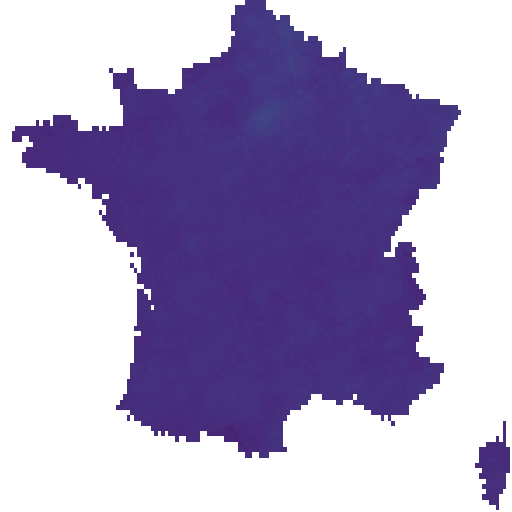

In [8]:
# get PNG bytes from API
image_bytes = re.post(
    f"{RASTER_API_URL}/cog/crop", 
    params={
        "format": "png",
        "height": 512, 
        "width": 512, 
        "url":items[0]["assets"]["cog_default"]["href"],
        "rescale": f"{COG_DEFAULT['min']},{COG_DEFAULT['max']}",
        "colormap_name": "viridis"
    },
    json=france_aoi
).content

# Write to temporary file in order to display
f = tempfile.NamedTemporaryFile(suffix=".png") 
f.write(image_bytes)   

# display PNG!
display.Image(filename=f.name, height=512, width=512)

## Generating a GIF

To generate a GIF we request a PNG for each STAC Item and then use the Python Imaging Library (PIL) to combine them into a GIF. We will use a temporary directory to store all the generated PNGs and we will use multi-threading to speed up the operation.

Gather frames: 20.08 seconds


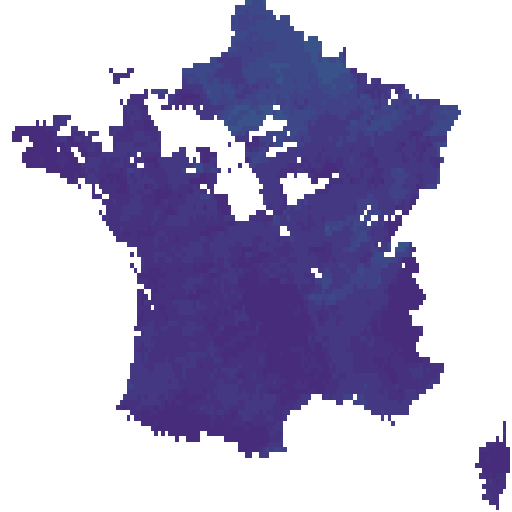

In [9]:
# for convenience we will wrap the API call from above into a method that will 
# save the contents of the PNG file into a file stored within the temp directory 

def save_png(item, geojson, dir_path): 
    filepath = os.path.join(dir_path, item["id"].replace(".nc", f".tif"))
    with open(filepath, "wb") as f: 
        f.write(
          re.post(
            f"{RASTER_API_URL}/cog/crop", 
                params={
                    "format": "png",
                    "height": 512, 
                    "width": 512, 
                    "url":item["assets"]["cog_default"]["href"],
                    "rescale":f"{COG_DEFAULT['min']},{COG_DEFAULT['max']}",
                    "colormap_name":"viridis"
                },
                json=geojson
            ).content 
        )
    return filepath

# temporary directory to hold PNGs
with tempfile.TemporaryDirectory() as tmpdirname:
    
    start = time.time()
    
    with ThreadPoolExecutor(max_workers=10) as executor: 
        result = list(executor.map(save_png, items, [france_aoi for _ in items],[tmpdirname for _ in items]))
    
    end = time.time()

    print(f"Gather frames: {round((end-start), 2)} seconds")

    imgs = (Image.open(f) for f in sorted(glob.glob(os.path.join(tmpdirname, "*.tif"))))
    img = next(imgs)  # extract first image from iterator
    img.save(fp="./output.gif", format='GIF', append_images=imgs, save_all=True, duration=300, loop=0)

display.Image(filename="./output.gif")

## Adding context

To provide more interesting or engaging data to the users, we can add temporal and geospatial context to the GIF. This is possible because API can return images in geo-referenced tif format. 

In [11]:
def save_tif(item, geojson, dir_path): 
    filepath = os.path.join(dir_path, item["id"].replace(".nc", f".tif"))
    with open(filepath, "wb") as f: 
        f.write(
          re.post(
            f"{RASTER_API_URL}/cog/crop", 
                params={
                    "format": "tif",
                    "height": 512, 
                    "width": 512, 
                    "url":item["assets"]["cog_default"]["href"],
                    "rescale":f"{COG_DEFAULT['min']},{COG_DEFAULT['max']}",
                    "colormap_name":"viridis"
                },
                json=geojson
            ).content 
        )
    return filepath

with tempfile.TemporaryDirectory() as tmpdirname:
    
    filepath = save_tif(items[0], france_aoi, tmpdirname)
    
    # Verify that the tif returned by the API is correctly georeferenced
    georeferenced_raster_data = rasterio.open(filepath)
    
    print("Data bounds: ", georeferenced_raster_data.bounds)
    print("Data CRS: ", georeferenced_raster_data.crs)


Data bounds:  BoundingBox(left=-5.132801886999943, bottom=41.365912177, right=9.559580925000091, top=51.08754088348043)
Data CRS:  EPSG:4326


### Overlaying GeoJSON: 
In order to overlay GeoJSON over the raster, we will have to convert the geojson boundaries to a raster format. We do this with the following steps: 

For each feature in the geojson we rasterize the feature into a mask. We use [binary dialation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_dilation.html?highlight=binary%20dilation#scipy.ndimage.binary_dilation) to detect the edges of the mask, and set the values corresponding to the mask edges to 255. This approach has one known problem: if multiple features share a border (eg: two adjoining provinces) the border between then will be detected twice, once from each side (or from each feature sharing that border). This means that internal borders will be twice as thick as external borders     

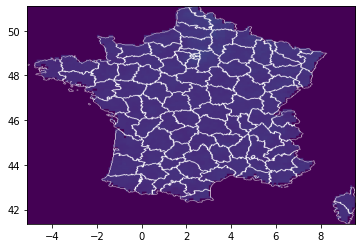

In [13]:
with tempfile.TemporaryDirectory() as tmpdirname:
    
    filepath = save_tif(items[0], france_aoi, tmpdirname)
    
    # Verify that the tif returned by the API is correctly georeferenced
    src = rasterio.open(filepath, "r+")
    arr = src.read()

    with open("./deps/france-departements.geojson", "r") as f: 
        geojson = json.loads(f.read())
    
    for feature in geojson["features"]:
        mask = rasterio.features.rasterize(
            ((feature["geometry"], 255),),
            fill=0,
            out_shape=src.shape,
            transform=src.transform,
            all_touched=False
        )
        dilated = binary_dilation(mask, iterations=1).astype(mask.dtype)
        outer = dilated > mask 
        arr = np.where(outer, 255, arr)

    # WARNING: Overwriting file
    src.write(arr)
    src.close()
    
    rasterio.plot.show(rasterio.open(filepath))

### Overlaying the raster on a basemap
Another way to contextualize where in the GIF's data is, is by overlaying the GIF on top of a base map. This process is a bit more complicated: 
- Generate a raster image (.tif)
- Overlay in on a folium map interface
- Save the map interface to html
- Open the html file with a headless chrome webdriver (using the selenium library)
- Save a screenshot of the rendered html as a .png

/var/folders/jh/_03qbqf130l8hjh8rpc6f4_c0000gn/T/ipykernel_15716/2437214881.py:41: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = selenium.webdriver.Chrome(executable_path="./deps/chromedriver", options=options)


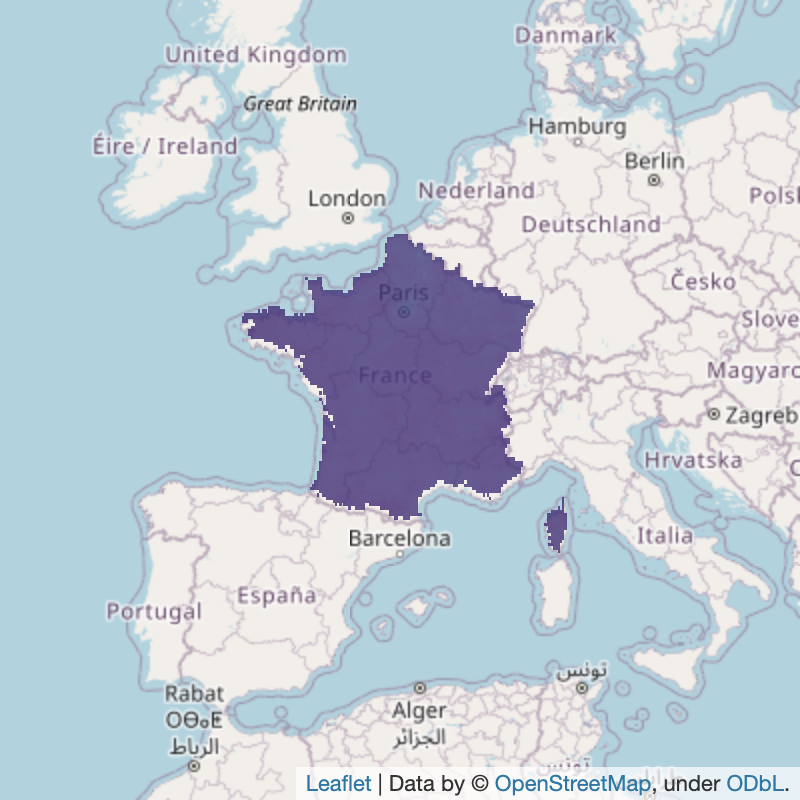

In [15]:
tmpdirname = tempfile.TemporaryDirectory() 
image_filepath = save_tif(items[0], france_aoi, tmpdirname.name)

with rasterio.open(image_filepath) as dataset:

    [lon_min, lat_min, lon_max, lat_max] = list(dataset.bounds)

    data = dataset.read()

    # reshape data from 3 x 512 x 512 to RGB (512 x 512 x 3)
    data_reshaped = np.zeros((data.shape[1], data.shape[2], data.shape[0]), 'uint8')
    data_reshaped[...,0] = data[0]
    data_reshaped[...,1] = data[1]
    data_reshaped[...,2] = data[2]
    data_reshaped[...,3] = data[3]

    # create folium base map over which to display each frame of the gif
    m = folium.Map(
        location=[(lat_max-lat_min)/2+lat_min, (lon_max-lon_min)/2+lon_min],
        zoom_start=4,
        zoom_control=False
    )

    # Add RGB image as overlay to folium map object
    image_overlay = folium.raster_layers.ImageOverlay(
        image=data_reshaped, 
        bounds=[[lat_min,lon_min],[lat_max, lon_max]], 
        opacity=0.80
    )
    image_overlay.add_to(m)

# use folium + selenium + geckodriver (webdriver) to convert folium HTML elements 
# (which now contain both the base map and the overlayed raster data) to a png 
# file and store locally
html_filepath = image_filepath.replace(".tif", ".html")

m.save(html_filepath)

options = selenium.webdriver.chrome.options.Options()
options.headless=True
driver = selenium.webdriver.Chrome(executable_path="./deps/chromedriver", options=options)
driver.set_window_size(400, 400)  # choose a resolution
driver.get(f"file://{html_filepath}")
time.sleep(2)
driver.save_screenshot(image_filepath.replace(".tif", ".png"))
display.Image(filename=image_filepath.replace(".tif", ".png"))
    

### Overlaying the Date: 
Now that we have the raster data displayed over the basemap, we want to add the date of each file 

/var/folders/jh/_03qbqf130l8hjh8rpc6f4_c0000gn/T/ipykernel_15716/2243000088.py:20: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  xs,ys = image_draw.textsize(datestring,  font=font)


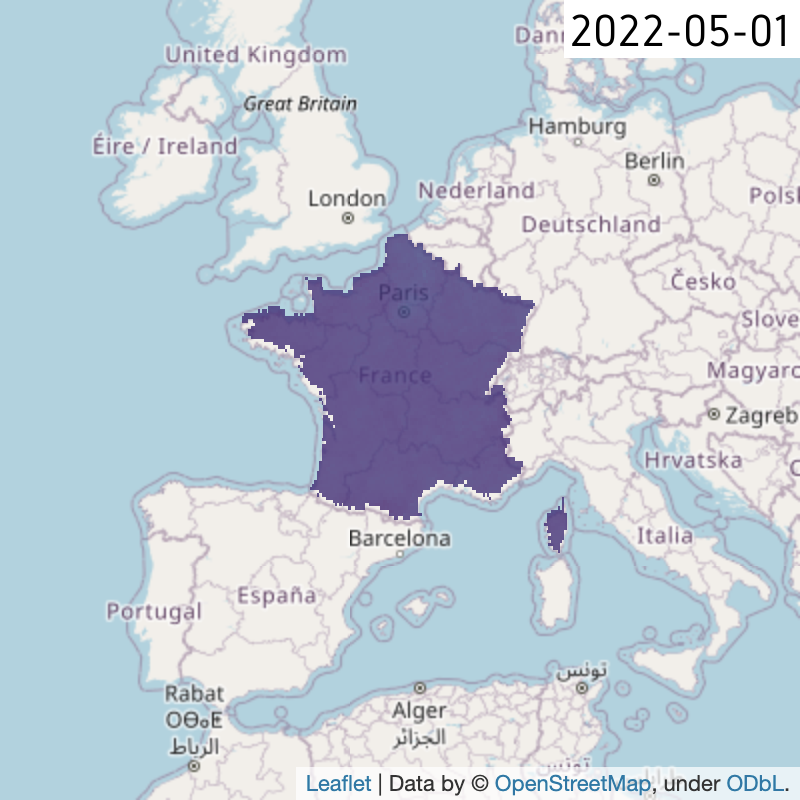

In [17]:
# Reuse the raster overlayed on the OSM basemap using folium from above: 

# Open the PNG file with PIL 
image = Image.open(image_filepath.replace(".tif", ".png"))

# Load draw module to add date string to png frame 
image_draw = ImageDraw.Draw(image)

# set font and size for date string
font = ImageFont.truetype("./deps/Gidole-Regular.ttf",size=45)

date = items[0]["properties"]["start_datetime"]

# get datestring from STAC Item properties and reformat
datestring = datetime.datetime.strptime(
        date, "%Y-%m-%dT%H:%M:%SZ"
    ).date().isoformat()

# calculate text size for date string
xs,ys = image_draw.textsize(datestring,  font=font)

# get image size to calculate date string position
image_width, image_height=image.size

# position date string background rectangle at in the lower left 
# hand corner with a 5px boundary between background rectangle 
# the datestring itself
text_rectangle_top_left = (image_width-xs-15,0)

# draw background rectangle
image_draw.rectangle(
    [ 
        text_rectangle_top_left, 
        (text_rectangle_top_left[0] + xs+15, text_rectangle_top_left[1] + ys+15) 
    ], 
    fill=(255,255,255))

# draw text over the background rectangle
image_draw.text(tuple(i+5 for i in text_rectangle_top_left), datestring, (0,0,0), font=font)

# Save output image
image.save(image_filepath.replace(".tif", ".png"))
display.Image(filename=image_filepath.replace(".tif", ".png"))

## Putting it all together
I've combined all of the above functionality, along with a few helper functions below

In [34]:
def get_image(item, geojson, image_format="tif", image_height=512, image_width=512, **kwargs):
    response = re.post(
        f"{RASTER_API_URL}/cog/crop", 
        params={
            "format": image_format,
            "height": image_height, 
            "width": image_width, 
            "url":item["assets"]["cog_default"]["href"],
            **kwargs
        },
        json=geojson
    ) 
    if not response.status_code == 200: 
        print(response.content)
        raise Exception
    return response.content

def overlay_geojson(image_filepath, geojson):
    with rasterio.open(image_filepath, "r+") as src:
        arr = src.read()
        
        # TODO: move validation logic higher up in the call stack
        if geojson["type"] == "FeatureCollection": 
            features = geojson["features"]
        elif geojson["type"] == "Feature": 
            features = [geojson]
        else: 
            raise Exception("Geojson to overlay must be either type Feature or FeatureCollection")
        
        for feature in geojson["features"]:
            mask = rasterio.features.rasterize(
                ((feature["geometry"], 255),),
                fill=0,
                out_shape=src.shape,
                transform=src.transform,
                all_touched=False
            )
            dilated = binary_dilation(mask, iterations=1).astype(mask.dtype)
            outer = dilated > mask 
            arr = np.where(outer, 255, arr)

        # WARNING: Overwriting file
        src.write(arr)
    return image_filepath

def overlay_raster_on_folium(image_filepath):
    # open with rasterio to get band data and bounds
    with rasterio.open(image_filepath) as dataset:

        [lon_min, lat_min, lon_max, lat_max] = list(dataset.bounds)

        data = dataset.read()

        # reshape data from 3 x 512 x 512 to RGB (512 x 512 x 3)
        data_reshaped = np.zeros((data.shape[1], data.shape[2], data.shape[0]), 'uint8')
        data_reshaped[...,0] = data[0]
        data_reshaped[...,1] = data[1]
        data_reshaped[...,2] = data[2]
        data_reshaped[...,3] = data[3]

        # create folium base map over which to display each frame of the gif
        m = folium.Map(
            location=[(lat_max-lat_min)/2+lat_min, (lon_max-lon_min)/2+lon_min],
            zoom_start=4,
            zoom_control=False
        )

        # Add RGB image as overlay to folium map object
        image_overlay = folium.raster_layers.ImageOverlay(
            image=data_reshaped, 
            bounds=[[lat_min,lon_min],[lat_max, lon_max]], 
            opacity=0.85
        )
        image_overlay.add_to(m)
    
    # use folium + selenium + geckodriver (webdriver) to convert folium HTML elements 
    # (which now contain both the base map and the overlayed raster data) to a png 
    # file and store locally
    html_filepath = image_filepath.replace(".tif", ".html")
    
    m.save(html_filepath)

    options = selenium.webdriver.chrome.options.Options()
    options.headless=True
    driver = selenium.webdriver.Chrome(executable_path="./deps/chromedriver", options=options)
    driver.set_window_size(400, 400)  # choose a resolution
    driver.get(f"file://{html_filepath}")
    time.sleep(2)
    driver.save_screenshot(image_filepath.replace(".tif", ".png"))

    return image_filepath

def overlay_date(image_filepath, datestring):
    
     # Open the PNG file with PIL 
    image = Image.open(image_filepath)
    
    # Load draw module to add date string to png frame 
    image_draw = ImageDraw.Draw(image)

    # set font and size for date string
    font = ImageFont.truetype("./deps/Gidole-Regular.ttf",size=45)
    
    # calculate text size for date string
    xs,ys = image_draw.textsize(datestring, font=font)

    # get image size to calculate date string position
    image_width, image_height=image.size

    # position date string background rectangle at in the lower left 
    # hand corner with a 5px boundary between background rectangle 
    # the datestring itself
    text_rectangle_top_left = (0,image_height-ys-15)

    # draw background rectangle
    image_draw.rectangle(
        [ 
            text_rectangle_top_left, 
            (text_rectangle_top_left[0] + xs + 15, text_rectangle_top_left[1] + ys + 15) 
        ], 
        fill=(255,255,255))

    # draw text over the background rectangle
    image_draw.text(tuple(i+5 for i in text_rectangle_top_left), datestring, (0,0,0), font=font)
    # Save output image
    image.save(image_filepath)
    
    return image_filepath


def generate_frame(item, aoi, dir_path, overlay, image_height=512, image_width=512):
    
    datestring = datetime.datetime.strptime(
            item["properties"]["start_datetime"], "%Y-%m-%dT%H:%M:%SZ"
        ).date().isoformat()  
    
    # prepend datestring in filename so that we can sort the files by alphabetical order
    # when generating the GIF
    filepath = os.path.join(dir_path, "_".join([datestring, item["id"].replace(".nc", f".tif")]))
    
    with open(filepath, "wb") as f: 
        f.write(
            get_image(
                item, 
                geojson=aoi, 
                image_format="tif",
                image_height=image_height, 
                image_width=image_width,
                rescale=f"{COG_DEFAULT['min']},{COG_DEFAULT['max']}",
                colormap_name="viridis"
            )
        )
    if overlay=="folium": 
        overlay_raster_on_folium(filepath)
        # folium screenshots get saved as png
        filepath = filepath.replace(".tif", ".png")
    else: 
        if not isinstance(overlay, dict):
            # TODO: add check for geojson validity (ie: Feature/FeatureCollection "type" field, etc)
            raise Exception("Param: overlay must be a valid geojson dict")
        
        overlay_geojson(filepath, overlay)     
    
    overlay_date(filepath, datestring)
    
    return filepath 

## Generate a GIF with geojson overlay: 

In [ ]:
with tempfile.TemporaryDirectory() as tmpdirname:
    start = time.time()
    
    with open("./deps/france-departements.geojson", "r") as f: 
        overlay = json.loads(f.read())
    with ThreadPoolExecutor(max_workers=10) as executor: 
        result = list(
            executor.map(
                generate_frame, 
                items, 
                [france_aoi for _ in items],
                [tmpdirname for _ in items],
                [overlay for _ in items]
            )
        )
    
    end = time.time()
    
    print(f"Gather frames: {round((end-start), 2)} seconds")

    imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(tmpdirname, "*.tif")))]
    imgs[0].save(fp="output_with_geojson.gif", format='GIF', append_images=imgs[1:], save_all=True, duration=300, loop=0)

display.Image(filename="output_with_geojson.gif")

## GIF with OSM basemap (folium)

In [ ]:
with tempfile.TemporaryDirectory() as tmpdirname:
    start = time.time()

    with ThreadPoolExecutor(max_workers=10) as executor: 
        result = list(executor.map(generate_frame, items,  [france_aoi for _ in items], [tmpdirname for _ in items], ["folium" for _ in items]))
    
    end = time.time()

    print(f"Gather frames: {round((end-start), 2)} seconds")

    # Note: I'm searching for `*.png` files instead of *.tif files because the webdriver screenshot
    # of the folium map interface is exported in png format (this also helps reduce the size of
    # the final gif )
    imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(tmpdirname, "*.png")))]
    imgs[0].save(fp="./output_with_osm_basemap.gif", format='GIF', append_images=imgs[1:], save_all=True, duration=300, loop=0)

display.Image(filename="./output_with_osm_basemap.gif")